# Linear regression with Eustatic Sea-level data

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/linear_regression/linear_regression_sealevel.ipynb)

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

---

## What we do in this notebook

Here we demonstrate use of CoFI on a real dataset **linear regression** problem, where we fit a polynomial function to Eustatic Sea-level heights.

- by solution of a linear system of equations,
- by optimization of a data misfit function
- by Bayesian sampling of a Likelihood multiplied by a prior.

---

Data set is from "Sea level and global ice volumes from the Last Glacial Maximum to the Holocene"
K. Lambeck, H. Rouby, A. Purcell, Y. Sun, and M. Sambridge, 2014. 
Proc. Nat. Acad. Sci., 111, no. 43, 15296-15303, doi:10.1073/pnas.1411762111.

In [1]:
# Environment setup (uncomment code below)

# !pip install -U cofi

Remember to uncomment and run the code cell below as well, as we are going to
load some data from GitHub.

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/linear_regression

## Linear regression

Lets start with some (x,y) data.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#
def load_data_xy(filename):

    f = open(filename, 'r')
    header = f.readline()
    lines = f.readlines()

    x = np.array([])
    y = np.array([])
    sx = np.array([])
    sy = np.array([])
    for line in lines:
        columns = line.split()
        x = np.append(x,float(columns[0]))
        y = np.append(y,float(columns[1]))
        sx = np.append(sx,float(columns[2])/2.0)
        sy = np.append(sy,float(columns[3])/2.0)

    d = x,y, sy                                   # Combine into a single data structure

    return d

def load_data_ref(filename):

    f = open(filename, 'r')
    lines = f.readlines()
    dx = np.array([]) # Age data
    dy = np.array([]) # ESL height
    dz = np.array([]) # derivative of ESL w.r.t. age
    for line in lines:
        columns = line.split()
        dx = np.append(dx,float(columns[0]))
        dy = np.append(dy,float(columns[1]))
    datavals = np.column_stack((dx,dy))  # Stack data

    return datavals

In [5]:
data_x,data_y,sy = load_data_xy("ESL-ff11-sorted.txt")  # Load x,sx,y,sy ESL data (x=time, Y=ESL)

In [6]:
maxtime = 20.
ndata = np.where(data_x>maxtime)[0][0]

In [7]:
data_x,data_y,sy = data_x[:ndata],data_y[:ndata],sy[:ndata]

And now lets plot the data.

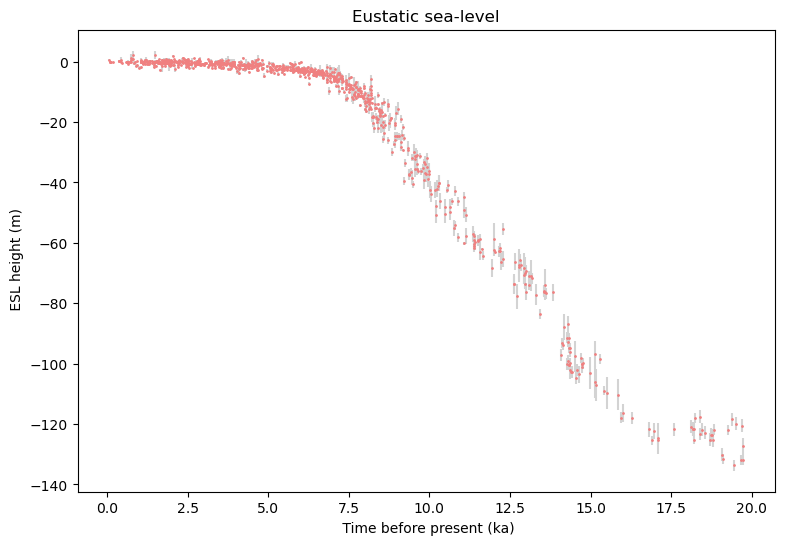

In [8]:
def plot_data(x=data_x,y=data_y,sigma=sy,title=None):
    fig, axes = plt.subplots(figsize=(9,6))
    plt.errorbar(x, y, yerr=sy, fmt='.',color="lightcoral",ecolor='lightgrey',ms=2)
    plt.xlabel(' Time before present (ka)')
    plt.ylabel(' ESL height (m)')
    if(title != None): plt.title(title)
plot_data(title='Eustatic sea-level')

## Problem description

To begin with, we will work with polynomial curves, $$y(x) = \sum_{j=0}^M m_j x^j\,.$$
Here, $M$ is the 'order' of the polynomial: if $M=1$ we have a straight line with 2 parameters, if $M=2$ it will be a quadratic with 3 parameters, and so on. The $m_j, (j=0,\dots M)$ are the 'model coefficients' that we seek to constrain from the data.

For this class of problem the forward operator takes the following form:

$$ \left(\begin{array}{c}y_0\\y_1\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_0&x_0^2&x_0^3\\1&x_1&x_1^2&x_1^3\\\vdots&\vdots&\vdots\\1&x_N&x_N^2&x_N^3\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$


This clearly has the required general form, $\mathbf{d} =G{\mathbf m}$.

where:

- $\textbf{d}$ is the vector of data values, ($y_0,y_1,\dots,y_N$);
- $\textbf{m}$ is the vector of model parameters, ($m_0,m_1,m_2$);
- $G$ is the basis matrix (or design matrix) of this linear regression problem (also called the ***Jacobian*** matrix for this linear problem).



We have a set of noisy data values, $y_i (i=0,\dots,N)$, measured at known locations, $x_i (i=0,\dots,N)$, and wish to find the best fit degree 3 polynomial.

The function that generated our data is assumed to have independent Gaussian random noise, ${\cal N}(0,\Sigma)$, with $(\Sigma)_{ij} = \delta_{ij}/\sigma_i^2$, where the variance of the noise on each datum, $\sigma_i^2 (i=1,\dots,N)$, differs between observations and is given.

We now build the Jacobian/G matrix for this problem and define a forward function which simply multiplies $\mathbf m$ by $G$.

In [9]:
nparams = 5 # Number of model parameters to be solved for

def jacobian(x=data_x, n=nparams):
    return np.array([x**i for i in range(n)]).T

def forward(model):
    return jacobian().dot(model)

def Cd_inv(sigma=sy):
    factor= 10                                   # factor to inflate observational errors
    return np.diag(1./sy*1./sy)/(factor**2)

Define a reference model for later.

In [10]:
# Reference model for plotting
ESLref = load_data_ref("ESL-f11_yonly.txt") # Load x, y, z reference model and estimated derivative (x=time, Y=ESL, z=dESL/dt) 
ndata2 = np.where(ESLref.T[0]>maxtime)[0][0]
ESLref = ESLref[:ndata2]
ref_x,ref_y = ESLref.T[0],ESLref.T[1]

Now lets plot the data with the reference curve

In [11]:
# Some plotting utilities
def plot_model(x,y, label, color=None,lw=0.5):
    plt.plot(x, y, color=color or "green", label=label,lw=lw)
    #plt.xlabel("X")
    #plt.ylabel("ESL")
    plt.legend()

def plot_models(models, label="Posterior samples", color="seagreen", alpha=0.1,lw=0.5):
    G = jacobian(data_x)
    plt.plot(data_x, G.dot(models[0]), color=color, label=label, alpha=alpha,lw=lw)
    for m in models:
        plt.plot(data_x, G.dot(m), color=color, alpha=alpha,lw=lw)
    plt.legend()

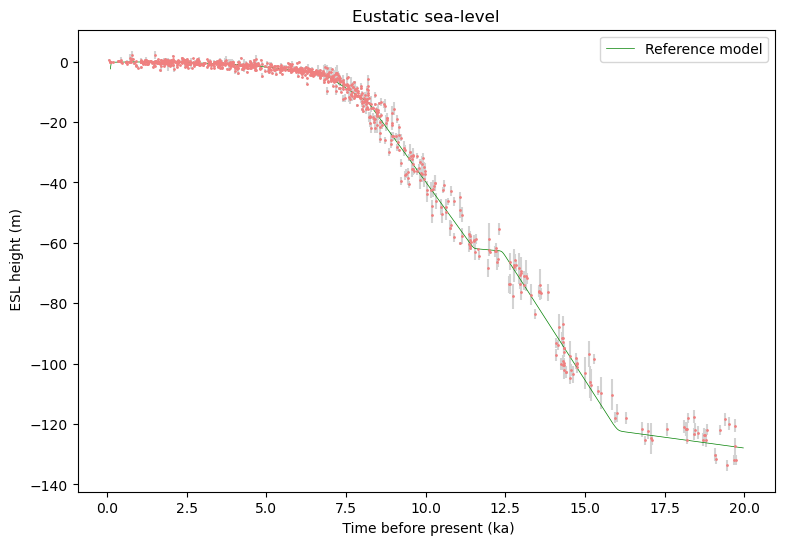

In [12]:
plot_data(title="Eustatic sea-level")
plot_model(ref_x,ref_y, "Reference model")

Now we have the data and the forward model we can start to try and estimate the coefficients of the polynomial from the data.

## The structure of CoFI <a name="CoFI-structure"></a>
In the workflow of `cofi`, there are three main 
components: `BaseProblem`, `InversionOptions`, and `Inversion`.

- `BaseProblem` defines the inverse problem including any user supplied quantities such as data vector, number of model parameters and measure of fit between model predictions and data. 
    ```python
    inv_problem = BaseProblem()
    inv_problem.set_objective(some_function_here)
    inv_problem.set_jacobian(some_function_here)
    inv_problem.set_initial_model(a_starting_point) # if needed, e.g. we are solving a nonlinear problem by optimization
    ```
    
    &nbsp; 
- `InversionOptions` describes details about how one wants to run the inversion, including the backend tool and solver-specific parameters. It is based on the concept of a `method` and `tool`.

    ```python
    inv_options = InversionOptions()
    inv_options.suggest_solving_methods()
    inv_options.set_solving_method("matrix solvers")
    inv_options.suggest_tools()
    inv_options.set_tool("scipy.linalg.lstsq")
    inv_options.summary()
    ```

    &nbsp; 
- `Inversion` can be seen as an inversion engine that takes in the above two as information,
  and will produce an `InversionResult` upon running.
  
    ```python
    inv = Inversion(inv_problem, inv_options)
    result = inv.run()
    ```
 
 Internally CoFI decides the nature of the problem from the quantities set by the user and performs internal checks to ensure it has all that it needs to solve a problem.

## 1. Linear system solver

In [13]:
from cofi import BaseProblem, InversionOptions, Inversion

### Step 1. Define CoFI `BaseProblem`

In [14]:
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian())
inv_problem.set_data_covariance_inv(Cd_inv())

### Step 2. Define CoFI `InversionOptions`

In [15]:
inv_options = InversionOptions()

Using the information supplied, we can ask CoFI to suggest some solving methods.

In [16]:
inv_options.suggest_solving_methods()

The following solving methods are supported:
{'matrix solvers', 'optimization', 'sampling'}

Use `suggest_tools()` to see a full list of backend tools for each method


We can ask CoFI to suggest some specific software tools as well. 

In [17]:
inv_options.suggest_tools()

Here's a complete list of inversion tools supported by CoFI (grouped by methods):
{
    "optimization": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares",
        "torch.optim"
    ],
    "matrix solvers": [
        "scipy.linalg.lstsq",
        "cofi.simple_newton"
    ],
    "sampling": [
        "emcee"
    ]
}


In [18]:
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv_options.summary()

Summary for inversion options
Solving method: matrix solvers
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `<class 'cofi.tools._scipy_lstsq.ScipyLstSq'> (by default)` - SciPy's wrapper function over LAPACK's linear least-squares solver, using 'gelsd', 'gelsy' (default), or 'gelss' as backend driver
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html', 'https://www.netlib.org/lapack/lug/node27.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: None set
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [19]:
# below is optional, as this has already been the default tool under "linear least square"
inv_options.set_tool("scipy.linalg.lstsq")

### Step 3. Define CoFI `Inversion` and run

Our choices so far have defined a linear parameter estimation problem (without any regularization) to be solved within a least squares framework. In this case 
the selection of a `matrix solvers` method will mean we are calculating the standard least squares solution 

$$
m = (G^T C_d^{-1} G)^{-1} G^T C_d^{-1} d
$$

and our choice of backend tool `scipy.linalg.lstsq`, means that we will employ scipy's `linalg` package to perform the numerics.

Lets run CoFI.

In [20]:
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

In [21]:
print(f"The inversion result from `scipy.linalg.lstsq`: {inv_result.model}\n")
inv_result.summary()

The inversion result from `scipy.linalg.lstsq`: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]

Summary for inversion result
SUCCESS
----------------------------
model: [ 1.44051039 -3.11381469  1.412872   -0.20910136  0.00653572]
sum_of_squared_residuals: []
effective_rank: 5
singular_values: [1.72339368e+09 1.35569994e+06 3.54123758e+03 1.10384400e+02
 7.16903392e+00]
model_covariance: [[ 6.70145209e-02 -6.28173834e-02  1.67266578e-02 -1.60867740e-03
   4.77025592e-05]
 [-6.28173834e-02  7.43365995e-02 -2.23488563e-02  2.32179303e-03
  -7.20214235e-05]
 [ 1.67266578e-02 -2.23488563e-02  7.38371078e-03 -8.20763652e-04
   2.65025504e-05]
 [-1.60867740e-03  2.32179303e-03 -8.20763652e-04  9.62437921e-05
  -3.21300646e-06]
 [ 4.77025592e-05 -7.20214235e-05  2.65025504e-05 -3.21300646e-06
   1.10114955e-07]]


Lets plot the solution.

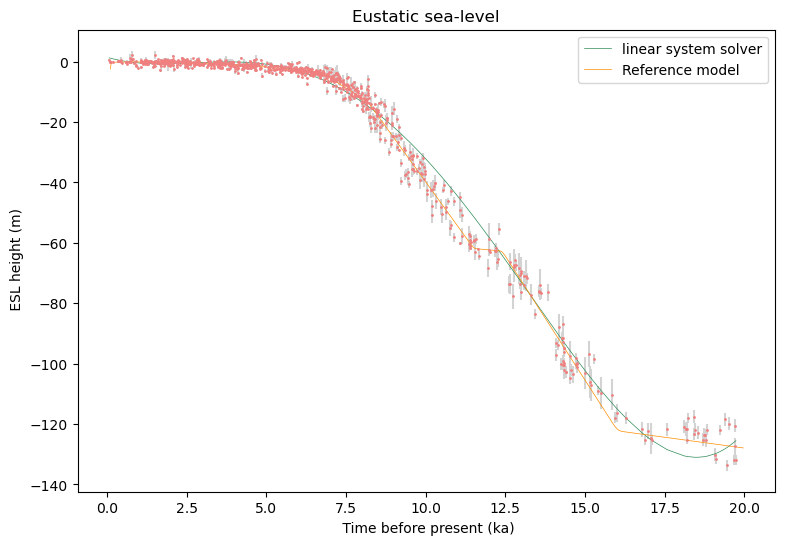

In [22]:
plot_data(title="Eustatic sea-level")
plot_model(data_x,jacobian(data_x).dot(inv_result.model), "linear system solver", color="seagreen")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

## 2. Optimizer

The same overdetermined linear problem, $\textbf{d} = G\textbf{m}$, with Gaussian data noise can also be solved by minimising the squares of the 
residual of the linear equations, e.g. $\textbf{r}^T \textbf{C}_d^{-1}\textbf{r}$ where 
$\textbf{r}=\textbf{d}-G\textbf{m}$. The above matrix solver solution gives us the best data fitting model, but a direct optimisation approach could also be used, say when the number of unknowns is large and we do not wish, or are unable to provide the Jacobian function.

So we use a plain optimizer `scipy.optimize.minimize` to demonstrate this ability.

<!-- For this backend solver to run successfully, some additional information should be provided, otherwise
you'll see an error to notify what additional information is required by the solver.

There are several ways to provide the information needed to solve an inverse problem with 
CoFI. In the example below we provide functions to calculate the data and the optional 
regularisation. CoFI then generates the objective function for us based on the information 
provided. The alternative to this would be to directly provide objective function to CoFI. -->

In [23]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_initial_model(np.ones(nparams))
#inv_problem.set_initial_model(inv_result.model)
inv_problem.set_forward(forward)
inv_problem.set_data_misfit("squared error")

# inv_problem.set_objective(your_own_misfit_function)    # (optionally) if you'd like to define your own misfit
# inv_problem.set_gradient(your_own_gradient_of_misfit_function)    # (optionally) if you'd like to define your own misfit gradient

######## CoFI InversionOptions - set a different tool
inv_options_2 = InversionOptions()
inv_options_2.set_tool("scipy.optimize.minimize")
inv_options_2.set_params(method="Nelder-Mead")

######## CoFI Inversion - run it
inv_2 = Inversion(inv_problem, inv_options_2)
inv_result_2 = inv_2.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `scipy.optimize.minimize`: {inv_result_2.model}\n")
inv_result_2.summary()

The inversion result from `scipy.optimize.minimize`: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]

Summary for inversion result
FAILURE
----------------------------
fun: 396.30180936007037
nit: 598
nfev: 1000
status: 1
message: Maximum number of function evaluations has been exceeded.
final_simplex: (array([[ 4.02211771, -7.6352002 ,  3.47983694, -0.52237961,  0.02043681],
       [ 4.02227491, -7.63498804,  3.47977907, -0.52238912,  0.02043829],
       [ 4.02218792, -7.63507241,  3.47979137, -0.5223722 ,  0.02043577],
       [ 4.02245903, -7.63488993,  3.47966829, -0.52235893,  0.02043602],
       [ 4.02257488, -7.63525136,  3.47962954, -0.52233062,  0.02043424],
       [ 4.02215782, -7.63502984,  3.47981924, -0.5223883 ,  0.02043736]]), array([396.30180936, 396.30181593, 396.30181983, 396.30182837,
       396.30183836, 396.30184074]))
model: [ 4.02211771 -7.6352002   3.47983694 -0.52237961  0.02043681]


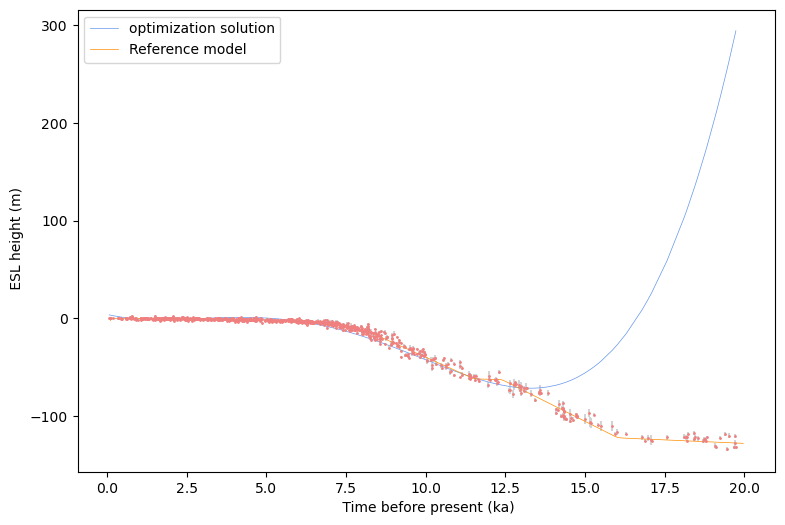

In [24]:
plot_data()
plot_model(data_x,jacobian(data_x).dot(inv_result_2.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

The optimization fails to convergence for this problem (with default settings). 

-------

### Challenge - Change the polynomial degree

Try and replace the 3rd order polynomial with a 2nd order polynomial (i.e. $M=2$) by adding the required commands below. What does the plot looks like? 

Start from code below:

```
inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=<CHANGE ME>))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = <CHANGE ME> ")
plot_data()
plot_model(data_x,jacobian(x,n=<CHANGE ME>).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

```


In [25]:
# Copy the template above, Replace <CHANGE ME> with your answer



Inferred curve with n = 3 


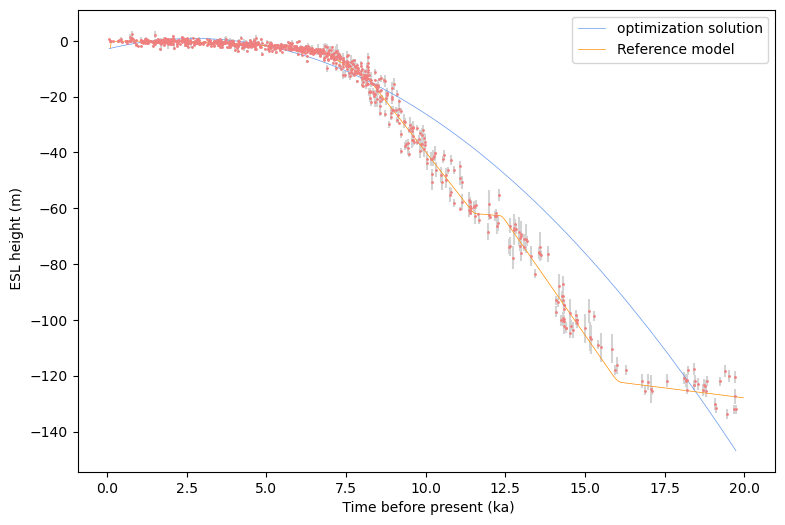

In [26]:
#@title Solution

inv_problem = BaseProblem()
inv_problem.set_data(data_y)
inv_problem.set_jacobian(jacobian(n=3))
inv_problem.set_data_covariance_inv(Cd_inv())
inv_options.set_solving_method("matrix solvers") # lets decide to use a matrix solver.
inv = Inversion(inv_problem, inv_options)
inv_result = inv.run()

print("Inferred curve with n = 3 ")
plot_data()
plot_model(data_x,jacobian(data_x,n=3).dot(inv_result.model), "optimization solution", color="cornflowerblue")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")

Changing to a second order polynomial does converge but gives a poor fit.

-------

## 3. Bayesian sampling


### Likelihood

Since data errors follow a Gaussian in this example, we can define a Likelihood function, $p({\mathbf d}_{obs}| {\mathbf m})$. 

$$
p({\mathbf d}_{obs} | {\mathbf m}) \propto \exp \left\{- \frac{1}{2} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m}))^T C_D^{-1} ({\mathbf d}_{obs}-{\mathbf d}_{pred}({\mathbf m})) \right\}
$$

where ${\mathbf d}_{obs}$ represents the observed y values and ${\mathbf d}_{pred}({\mathbf m})$ are those predicted by the polynomial model $({\mathbf m})$. The Likelihood is defined as the probability of observing the data actually observed, given a model. In practice we usually only need to evaluate the log of the Likelihood, $\log p({\mathbf d}_{obs} | {\mathbf m})$.
To do so, we require the inverse data covariance matrix describing the statistics of the noise in the data, $C_D^{-1}$ . For this problem the data errors are independent with identical standard deviation in noise for each datum. Hence $C_D^{-1} = \frac{1}{\sigma^2}I$ where $\sigma=1$.

Here we artificially increase the observational errors on the data so that the spread of the posterior samples are visible.

In [27]:
Cdinv = Cd_inv()                 # inverse data covariance matrix

def log_likelihood(model):
    y_synthetics = forward(model)
    residual = data_y - y_synthetics
    return -0.5 * residual @ (Cdinv @ residual).T

Note that the user could specify **any appropriate Likelihood function** of their choosing here.

### Prior

Bayesian sampling requires a prior probability density function. A common problem with polynomial coefficients as model parameters is that it is not at all obvious what a prior should be. Here we choose a uniform prior with specified bounds

$$
\begin{align}
p({\mathbf m}) &= \frac{1}{V},\quad  l_i \le m_i \le u_i, \quad (i=1,\dots,M)\\
\\
         &= 0, \quad {\rm otherwise},
\end{align}
$$

where $l_i$ and $u_i$ are lower and upper bounds on the $i$th model coefficient.

Here use the uniform distribution with ${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

In [28]:
m_lower_bound = np.ones(nparams) * (-10.)             # lower bound for uniform prior
m_upper_bound = np.ones(nparams) * 10                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

Note that the user could specify **any appropriate Prior PDF** of their choosing here.

### Bayesian sampling

In this aproach we sample a probability distribution rather than find a single best fit solution. Bayes' theorem tells us the the posterior distribution is proportional to the Likelihood and the prior.

$$p(\mathbf{m}|\mathbf{d}) = K p(\mathbf{d}|\mathbf{m})p(\mathbf{m})$$

where $K$ is some constant. Under the assumptions specified $p(\mathbf{m}|\mathbf{d})$ gives a probability density of models that are supported by the data. We seek to draw random samples from $p(\mathbf{m}|\mathbf{d})$ over model space and then to make inferences from the resulting ensemble of model parameters.

In this example we make use of *The Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler*
[Goodman and Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) to sample the
posterior distribution of the model. (See more details about [emcee](https://emcee.readthedocs.io/en/stable/)).

### Starting points for random walkers

Now we define some hyperparameters (e.g. the number of walkers and steps), and initialise
the starting positions of walkers. We start all walkers in a small ball about a chosen point
$(0, 0, 0, 0)$.

In [29]:
nwalkers = 32
ndim = nparams
nsteps = 10000
walkers_start = np.zeros(nparams) + 1e-4 * np.random.randn(nwalkers, ndim)

### Add the information and run with CoFI

In [30]:
######## CoFI BaseProblem - provide additional information
inv_problem.set_log_prior(log_prior)
inv_problem.set_log_likelihood(log_likelihood)
inv_problem.set_model_shape(ndim)

######## CoFI InversionOptions - get a different tool
inv_options_3 = InversionOptions()
inv_options_3.set_tool("emcee")      # Here we use to Affine Invariant McMC sampler from Goodman and Weare (2010).
inv_options_3.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True, initial_state=walkers_start)

######## CoFI Inversion - run it
inv_3 = Inversion(inv_problem, inv_options_3)
inv_result_3 = inv_3.run()

######## CoFI InversionResult - check result
print(f"The inversion result from `emcee`:")
inv_result_3.summary()

  0%|                                                                                                                                           | 0/10000 [00:00<?, ?it/s]

  0%|▎                                                                                                                                | 21/10000 [00:00<00:49, 200.04it/s]

  0%|▌                                                                                                                                | 42/10000 [00:00<00:50, 197.32it/s]

  1%|▊                                                                                                                                | 62/10000 [00:00<00:51, 193.80it/s]

  1%|█                                                                                                                                | 82/10000 [00:00<00:51, 193.94it/s]

  1%|█▎                                                                                                                              | 102/10000 [00:00<00:53, 183.55it/s]

  1%|█▌                                                                                                                              | 122/10000 [00:00<00:52, 187.21it/s]

  1%|█▊                                                                                                                              | 141/10000 [00:00<00:58, 168.05it/s]

  2%|██                                                                                                                              | 159/10000 [00:00<01:02, 157.70it/s]

  2%|██▎                                                                                                                             | 176/10000 [00:01<01:04, 151.51it/s]

  2%|██▍                                                                                                                             | 192/10000 [00:01<01:06, 147.23it/s]

  2%|██▋                                                                                                                             | 207/10000 [00:01<01:08, 143.38it/s]

  2%|██▊                                                                                                                             | 222/10000 [00:01<01:10, 139.29it/s]

  2%|███                                                                                                                             | 236/10000 [00:01<01:10, 138.79it/s]

  2%|███▏                                                                                                                            | 250/10000 [00:01<01:10, 138.39it/s]

  3%|███▍                                                                                                                            | 264/10000 [00:01<01:10, 138.62it/s]

  3%|███▌                                                                                                                            | 278/10000 [00:01<01:10, 138.79it/s]

  3%|███▊                                                                                                                            | 293/10000 [00:01<01:09, 139.23it/s]

  3%|███▉                                                                                                                            | 307/10000 [00:01<01:09, 138.77it/s]

  3%|████                                                                                                                            | 321/10000 [00:02<01:09, 138.76it/s]

  3%|████▎                                                                                                                           | 335/10000 [00:02<01:09, 138.47it/s]

  3%|████▍                                                                                                                           | 349/10000 [00:02<01:12, 133.90it/s]

  4%|████▋                                                                                                                           | 363/10000 [00:02<01:11, 134.78it/s]

  4%|████▊                                                                                                                           | 377/10000 [00:02<01:11, 134.89it/s]

  4%|█████                                                                                                                           | 391/10000 [00:02<01:11, 135.24it/s]

  4%|█████▏                                                                                                                          | 405/10000 [00:02<01:11, 133.88it/s]

  4%|█████▎                                                                                                                          | 419/10000 [00:02<01:11, 134.81it/s]

  4%|█████▌                                                                                                                          | 433/10000 [00:02<01:10, 135.40it/s]

  4%|█████▋                                                                                                                          | 447/10000 [00:03<01:10, 135.91it/s]

  5%|█████▉                                                                                                                          | 461/10000 [00:03<01:09, 136.42it/s]

  5%|██████                                                                                                                          | 475/10000 [00:03<01:09, 136.43it/s]

  5%|██████▎                                                                                                                         | 489/10000 [00:03<01:09, 136.75it/s]

  5%|██████▍                                                                                                                         | 503/10000 [00:03<01:09, 136.99it/s]

  5%|██████▌                                                                                                                         | 517/10000 [00:03<01:09, 136.92it/s]

  5%|██████▊                                                                                                                         | 531/10000 [00:03<01:09, 137.05it/s]

  5%|██████▉                                                                                                                         | 545/10000 [00:03<01:08, 137.36it/s]

  6%|███████▏                                                                                                                        | 559/10000 [00:03<01:08, 137.57it/s]

  6%|███████▎                                                                                                                        | 573/10000 [00:03<01:08, 137.64it/s]

  6%|███████▌                                                                                                                        | 587/10000 [00:04<01:08, 137.76it/s]

  6%|███████▋                                                                                                                        | 601/10000 [00:04<01:08, 137.90it/s]

  6%|███████▊                                                                                                                        | 615/10000 [00:04<01:08, 137.92it/s]

  6%|████████                                                                                                                        | 629/10000 [00:04<01:07, 138.10it/s]

  6%|████████▏                                                                                                                       | 643/10000 [00:04<01:08, 137.15it/s]

  7%|████████▍                                                                                                                       | 657/10000 [00:04<01:07, 137.53it/s]

  7%|████████▌                                                                                                                       | 671/10000 [00:04<01:07, 137.40it/s]

  7%|████████▊                                                                                                                       | 685/10000 [00:04<01:08, 136.80it/s]

  7%|████████▉                                                                                                                       | 699/10000 [00:04<01:08, 136.39it/s]

  7%|█████████▏                                                                                                                      | 713/10000 [00:04<01:07, 136.85it/s]

  7%|█████████▎                                                                                                                      | 727/10000 [00:05<01:07, 136.89it/s]

  7%|█████████▍                                                                                                                      | 741/10000 [00:05<01:07, 137.32it/s]

  8%|█████████▋                                                                                                                      | 755/10000 [00:05<01:07, 137.33it/s]

  8%|█████████▊                                                                                                                      | 769/10000 [00:05<01:07, 137.54it/s]

  8%|██████████                                                                                                                      | 783/10000 [00:05<01:16, 120.09it/s]

  8%|██████████▏                                                                                                                     | 796/10000 [00:05<01:15, 121.80it/s]

  8%|██████████▎                                                                                                                     | 809/10000 [00:05<01:14, 123.68it/s]

  8%|██████████▌                                                                                                                     | 823/10000 [00:05<01:11, 127.88it/s]

  8%|██████████▋                                                                                                                     | 837/10000 [00:05<01:09, 130.91it/s]

  9%|██████████▉                                                                                                                     | 851/10000 [00:06<01:08, 132.81it/s]

  9%|███████████                                                                                                                     | 865/10000 [00:06<01:07, 134.35it/s]

  9%|███████████▎                                                                                                                    | 879/10000 [00:06<01:07, 135.08it/s]

  9%|███████████▍                                                                                                                    | 893/10000 [00:06<01:07, 135.79it/s]

  9%|███████████▌                                                                                                                    | 907/10000 [00:06<01:06, 136.70it/s]

  9%|███████████▊                                                                                                                    | 921/10000 [00:06<01:07, 135.34it/s]

  9%|███████████▉                                                                                                                    | 935/10000 [00:06<01:06, 136.13it/s]

  9%|████████████▏                                                                                                                   | 949/10000 [00:06<01:06, 136.88it/s]

 10%|████████████▎                                                                                                                   | 963/10000 [00:06<01:05, 137.49it/s]

 10%|████████████▌                                                                                                                   | 977/10000 [00:06<01:06, 136.15it/s]

 10%|████████████▋                                                                                                                   | 991/10000 [00:07<01:06, 134.81it/s]

 10%|████████████▊                                                                                                                  | 1005/10000 [00:07<01:06, 135.94it/s]

 10%|████████████▉                                                                                                                  | 1019/10000 [00:07<01:05, 136.74it/s]

 10%|█████████████                                                                                                                  | 1033/10000 [00:07<01:05, 137.30it/s]

 10%|█████████████▎                                                                                                                 | 1047/10000 [00:07<01:05, 137.73it/s]

 11%|█████████████▍                                                                                                                 | 1061/10000 [00:07<01:04, 138.02it/s]

 11%|█████████████▋                                                                                                                 | 1075/10000 [00:07<01:04, 137.91it/s]

 11%|█████████████▊                                                                                                                 | 1089/10000 [00:07<01:04, 137.85it/s]

 11%|██████████████                                                                                                                 | 1103/10000 [00:07<01:04, 137.96it/s]

 11%|██████████████▏                                                                                                                | 1117/10000 [00:07<01:04, 137.99it/s]

 11%|██████████████▎                                                                                                                | 1131/10000 [00:08<01:05, 135.93it/s]

 11%|██████████████▌                                                                                                                | 1145/10000 [00:08<01:04, 136.81it/s]

 12%|██████████████▋                                                                                                                | 1159/10000 [00:08<01:04, 137.33it/s]

 12%|██████████████▉                                                                                                                | 1173/10000 [00:08<01:04, 137.87it/s]

 12%|███████████████                                                                                                                | 1187/10000 [00:08<01:03, 138.13it/s]

 12%|███████████████▎                                                                                                               | 1201/10000 [00:08<01:03, 138.20it/s]

 12%|███████████████▍                                                                                                               | 1215/10000 [00:08<01:04, 136.52it/s]

 12%|███████████████▌                                                                                                               | 1229/10000 [00:08<01:03, 137.06it/s]

 12%|███████████████▊                                                                                                               | 1243/10000 [00:08<01:03, 137.49it/s]

 13%|███████████████▉                                                                                                               | 1257/10000 [00:08<01:03, 137.91it/s]

 13%|████████████████▏                                                                                                              | 1271/10000 [00:09<01:03, 138.23it/s]

 13%|████████████████▎                                                                                                              | 1285/10000 [00:09<01:03, 138.31it/s]

 13%|████████████████▍                                                                                                              | 1299/10000 [00:09<01:02, 138.42it/s]

 13%|████████████████▋                                                                                                              | 1313/10000 [00:09<01:02, 138.52it/s]

 13%|████████████████▊                                                                                                              | 1327/10000 [00:09<01:02, 138.56it/s]

 13%|█████████████████                                                                                                              | 1341/10000 [00:09<01:02, 138.58it/s]

 14%|█████████████████▏                                                                                                             | 1355/10000 [00:09<01:02, 138.30it/s]

 14%|█████████████████▍                                                                                                             | 1369/10000 [00:09<01:02, 138.10it/s]

 14%|█████████████████▌                                                                                                             | 1383/10000 [00:09<01:04, 134.36it/s]

 14%|█████████████████▋                                                                                                             | 1397/10000 [00:10<01:03, 134.52it/s]

 14%|█████████████████▉                                                                                                             | 1411/10000 [00:10<01:03, 135.95it/s]

 14%|██████████████████                                                                                                             | 1426/10000 [00:10<01:02, 137.18it/s]

 14%|██████████████████▎                                                                                                            | 1441/10000 [00:10<01:01, 138.11it/s]

 15%|██████████████████▍                                                                                                            | 1455/10000 [00:10<01:01, 138.59it/s]

 15%|██████████████████▋                                                                                                            | 1469/10000 [00:10<01:01, 138.99it/s]

 15%|██████████████████▊                                                                                                            | 1483/10000 [00:10<01:01, 139.20it/s]

 15%|███████████████████                                                                                                            | 1497/10000 [00:10<01:01, 139.24it/s]

 15%|███████████████████▏                                                                                                           | 1511/10000 [00:10<01:00, 139.34it/s]

 15%|███████████████████▎                                                                                                           | 1525/10000 [00:10<01:00, 139.19it/s]

 15%|███████████████████▌                                                                                                           | 1539/10000 [00:11<01:01, 137.63it/s]

 16%|███████████████████▋                                                                                                           | 1554/10000 [00:11<01:01, 138.46it/s]

 16%|███████████████████▉                                                                                                           | 1569/10000 [00:11<01:00, 139.02it/s]

 16%|████████████████████                                                                                                           | 1583/10000 [00:11<01:00, 139.14it/s]

 16%|████████████████████▎                                                                                                          | 1597/10000 [00:11<01:00, 139.24it/s]

 16%|████████████████████▍                                                                                                          | 1612/10000 [00:11<01:00, 139.53it/s]

 16%|████████████████████▋                                                                                                          | 1626/10000 [00:11<01:00, 139.36it/s]

 16%|████████████████████▊                                                                                                          | 1640/10000 [00:11<01:00, 138.42it/s]

 17%|█████████████████████                                                                                                          | 1654/10000 [00:11<01:00, 138.08it/s]

 17%|█████████████████████▏                                                                                                         | 1668/10000 [00:11<01:00, 138.63it/s]

 17%|█████████████████████▎                                                                                                         | 1682/10000 [00:12<01:00, 138.57it/s]

 17%|█████████████████████▌                                                                                                         | 1696/10000 [00:12<00:59, 138.95it/s]

 17%|█████████████████████▋                                                                                                         | 1710/10000 [00:12<00:59, 139.23it/s]

 17%|█████████████████████▉                                                                                                         | 1724/10000 [00:12<00:59, 139.27it/s]

 17%|██████████████████████                                                                                                         | 1738/10000 [00:12<00:59, 139.34it/s]

 18%|██████████████████████▎                                                                                                        | 1752/10000 [00:12<00:59, 139.34it/s]

 18%|██████████████████████▍                                                                                                        | 1766/10000 [00:12<00:59, 139.40it/s]

 18%|██████████████████████▌                                                                                                        | 1780/10000 [00:12<00:58, 139.40it/s]

 18%|██████████████████████▊                                                                                                        | 1794/10000 [00:12<00:58, 139.47it/s]

 18%|██████████████████████▉                                                                                                        | 1808/10000 [00:12<00:59, 138.65it/s]

 18%|███████████████████████▏                                                                                                       | 1822/10000 [00:13<00:58, 138.97it/s]

 18%|███████████████████████▎                                                                                                       | 1836/10000 [00:13<00:59, 138.27it/s]

 18%|███████████████████████▍                                                                                                       | 1850/10000 [00:13<00:58, 138.64it/s]

 19%|███████████████████████▋                                                                                                       | 1864/10000 [00:13<00:58, 139.01it/s]

 19%|███████████████████████▊                                                                                                       | 1878/10000 [00:13<00:58, 138.32it/s]

 19%|████████████████████████                                                                                                       | 1892/10000 [00:13<00:58, 138.75it/s]

 19%|████████████████████████▏                                                                                                      | 1906/10000 [00:13<00:58, 138.49it/s]

 19%|████████████████████████▍                                                                                                      | 1920/10000 [00:13<00:58, 138.82it/s]

 19%|████████████████████████▌                                                                                                      | 1935/10000 [00:13<00:57, 139.20it/s]

 19%|████████████████████████▊                                                                                                      | 1949/10000 [00:13<00:58, 138.41it/s]

 20%|████████████████████████▉                                                                                                      | 1963/10000 [00:14<00:57, 138.87it/s]

 20%|█████████████████████████                                                                                                      | 1977/10000 [00:14<00:57, 139.14it/s]

 20%|█████████████████████████▎                                                                                                     | 1992/10000 [00:14<00:57, 139.42it/s]

 20%|█████████████████████████▍                                                                                                     | 2006/10000 [00:14<00:57, 139.57it/s]

 20%|█████████████████████████▋                                                                                                     | 2021/10000 [00:14<00:57, 139.74it/s]

 20%|█████████████████████████▊                                                                                                     | 2035/10000 [00:14<00:56, 139.78it/s]

 20%|██████████████████████████                                                                                                     | 2049/10000 [00:14<00:57, 137.27it/s]

 21%|██████████████████████████▏                                                                                                    | 2063/10000 [00:14<00:57, 137.71it/s]

 21%|██████████████████████████▍                                                                                                    | 2077/10000 [00:14<00:57, 137.49it/s]

 21%|██████████████████████████▌                                                                                                    | 2092/10000 [00:15<00:57, 138.31it/s]

 21%|██████████████████████████▋                                                                                                    | 2106/10000 [00:15<00:56, 138.64it/s]

 21%|██████████████████████████▉                                                                                                    | 2121/10000 [00:15<00:56, 139.07it/s]

 21%|███████████████████████████                                                                                                    | 2135/10000 [00:15<00:56, 139.30it/s]

 21%|███████████████████████████▎                                                                                                   | 2149/10000 [00:15<00:56, 139.45it/s]

 22%|███████████████████████████▍                                                                                                   | 2163/10000 [00:15<00:56, 139.59it/s]

 22%|███████████████████████████▋                                                                                                   | 2177/10000 [00:15<00:56, 139.58it/s]

 22%|███████████████████████████▊                                                                                                   | 2191/10000 [00:15<00:56, 137.61it/s]

 22%|████████████████████████████                                                                                                   | 2205/10000 [00:15<00:56, 138.17it/s]

 22%|████████████████████████████▏                                                                                                  | 2219/10000 [00:15<00:56, 138.59it/s]

 22%|████████████████████████████▎                                                                                                  | 2233/10000 [00:16<00:56, 138.56it/s]

 22%|████████████████████████████▌                                                                                                  | 2247/10000 [00:16<00:55, 138.91it/s]

 23%|████████████████████████████▋                                                                                                  | 2261/10000 [00:16<00:55, 138.26it/s]

 23%|████████████████████████████▉                                                                                                  | 2275/10000 [00:16<00:55, 138.43it/s]

 23%|█████████████████████████████                                                                                                  | 2289/10000 [00:16<00:55, 138.67it/s]

 23%|█████████████████████████████▎                                                                                                 | 2304/10000 [00:16<00:55, 139.15it/s]

 23%|█████████████████████████████▍                                                                                                 | 2318/10000 [00:16<00:55, 139.15it/s]

 23%|█████████████████████████████▌                                                                                                 | 2332/10000 [00:16<00:55, 137.34it/s]

 23%|█████████████████████████████▊                                                                                                 | 2346/10000 [00:16<01:00, 126.67it/s]

 24%|█████████████████████████████▉                                                                                                 | 2359/10000 [00:17<01:04, 119.31it/s]

 24%|██████████████████████████████▏                                                                                                | 2374/10000 [00:17<01:00, 125.24it/s]

 24%|██████████████████████████████▎                                                                                                | 2389/10000 [00:17<00:58, 129.51it/s]

 24%|██████████████████████████████▌                                                                                                | 2404/10000 [00:17<00:57, 132.65it/s]

 24%|██████████████████████████████▋                                                                                                | 2418/10000 [00:17<00:56, 134.54it/s]

 24%|██████████████████████████████▉                                                                                                | 2433/10000 [00:17<00:55, 136.24it/s]

 24%|███████████████████████████████                                                                                                | 2448/10000 [00:17<00:54, 137.37it/s]

 25%|███████████████████████████████▎                                                                                               | 2462/10000 [00:17<00:55, 136.30it/s]

 25%|███████████████████████████████▍                                                                                               | 2476/10000 [00:17<00:54, 137.27it/s]

 25%|███████████████████████████████▌                                                                                               | 2490/10000 [00:17<00:55, 136.08it/s]

 25%|███████████████████████████████▊                                                                                               | 2504/10000 [00:18<00:54, 137.19it/s]

 25%|███████████████████████████████▉                                                                                               | 2519/10000 [00:18<00:54, 138.17it/s]

 25%|████████████████████████████████▏                                                                                              | 2533/10000 [00:18<00:53, 138.70it/s]

 25%|████████████████████████████████▎                                                                                              | 2548/10000 [00:18<00:53, 139.16it/s]

 26%|████████████████████████████████▌                                                                                              | 2563/10000 [00:18<00:53, 139.53it/s]

 26%|████████████████████████████████▋                                                                                              | 2577/10000 [00:18<00:53, 138.80it/s]

 26%|████████████████████████████████▉                                                                                              | 2591/10000 [00:18<00:53, 138.67it/s]

 26%|█████████████████████████████████                                                                                              | 2605/10000 [00:18<00:53, 138.36it/s]

 26%|█████████████████████████████████▎                                                                                             | 2619/10000 [00:18<00:53, 138.78it/s]

 26%|█████████████████████████████████▍                                                                                             | 2634/10000 [00:18<00:52, 139.26it/s]

 26%|█████████████████████████████████▋                                                                                             | 2648/10000 [00:19<00:52, 139.45it/s]

 27%|█████████████████████████████████▊                                                                                             | 2663/10000 [00:19<00:52, 139.69it/s]

 27%|██████████████████████████████████                                                                                             | 2678/10000 [00:19<00:52, 139.93it/s]

 27%|██████████████████████████████████▏                                                                                            | 2693/10000 [00:19<00:52, 140.05it/s]

 27%|██████████████████████████████████▍                                                                                            | 2708/10000 [00:19<00:51, 140.25it/s]

 27%|██████████████████████████████████▌                                                                                            | 2723/10000 [00:19<00:51, 140.27it/s]

 27%|██████████████████████████████████▊                                                                                            | 2738/10000 [00:19<00:51, 140.29it/s]

 28%|██████████████████████████████████▉                                                                                            | 2753/10000 [00:19<00:52, 137.66it/s]

 28%|███████████████████████████████████▏                                                                                           | 2768/10000 [00:19<00:52, 138.42it/s]

 28%|███████████████████████████████████▎                                                                                           | 2783/10000 [00:20<00:51, 138.98it/s]

 28%|███████████████████████████████████▌                                                                                           | 2798/10000 [00:20<00:51, 139.40it/s]

 28%|███████████████████████████████████▋                                                                                           | 2813/10000 [00:20<00:51, 139.61it/s]

 28%|███████████████████████████████████▉                                                                                           | 2828/10000 [00:20<00:51, 139.90it/s]

 28%|████████████████████████████████████                                                                                           | 2843/10000 [00:20<00:51, 140.06it/s]

 29%|████████████████████████████████████▎                                                                                          | 2858/10000 [00:20<00:50, 140.15it/s]

 29%|████████████████████████████████████▍                                                                                          | 2873/10000 [00:20<00:51, 138.34it/s]

 29%|████████████████████████████████████▋                                                                                          | 2887/10000 [00:20<00:51, 138.81it/s]

 29%|████████████████████████████████████▊                                                                                          | 2902/10000 [00:20<00:50, 139.32it/s]

 29%|█████████████████████████████████████                                                                                          | 2917/10000 [00:21<00:50, 139.63it/s]

 29%|█████████████████████████████████████▏                                                                                         | 2932/10000 [00:21<00:50, 139.91it/s]

 29%|█████████████████████████████████████▍                                                                                         | 2947/10000 [00:21<00:50, 140.12it/s]

 30%|█████████████████████████████████████▌                                                                                         | 2962/10000 [00:21<00:50, 140.16it/s]

 30%|█████████████████████████████████████▊                                                                                         | 2977/10000 [00:21<00:50, 140.25it/s]

 30%|█████████████████████████████████████▉                                                                                         | 2992/10000 [00:21<00:49, 140.39it/s]

 30%|██████████████████████████████████████▏                                                                                        | 3007/10000 [00:21<00:49, 140.42it/s]

 30%|██████████████████████████████████████▍                                                                                        | 3022/10000 [00:21<00:49, 140.43it/s]

 30%|██████████████████████████████████████▌                                                                                        | 3037/10000 [00:21<00:49, 140.39it/s]

 31%|██████████████████████████████████████▊                                                                                        | 3052/10000 [00:21<00:49, 140.47it/s]

 31%|██████████████████████████████████████▉                                                                                        | 3067/10000 [00:22<00:49, 140.45it/s]

 31%|███████████████████████████████████████▏                                                                                       | 3082/10000 [00:22<00:49, 140.19it/s]

 31%|███████████████████████████████████████▎                                                                                       | 3097/10000 [00:22<00:49, 140.26it/s]

 31%|███████████████████████████████████████▌                                                                                       | 3112/10000 [00:22<00:49, 140.32it/s]

 31%|███████████████████████████████████████▋                                                                                       | 3127/10000 [00:22<00:48, 140.44it/s]

 31%|███████████████████████████████████████▉                                                                                       | 3142/10000 [00:22<00:48, 140.42it/s]

 32%|████████████████████████████████████████                                                                                       | 3157/10000 [00:22<00:48, 140.30it/s]

 32%|████████████████████████████████████████▎                                                                                      | 3172/10000 [00:22<00:48, 140.33it/s]

 32%|████████████████████████████████████████▍                                                                                      | 3187/10000 [00:22<00:48, 140.32it/s]

 32%|████████████████████████████████████████▋                                                                                      | 3202/10000 [00:23<00:48, 140.41it/s]

 32%|████████████████████████████████████████▊                                                                                      | 3217/10000 [00:23<00:48, 140.51it/s]

 32%|█████████████████████████████████████████                                                                                      | 3232/10000 [00:23<00:48, 140.51it/s]

 32%|█████████████████████████████████████████▏                                                                                     | 3247/10000 [00:23<00:48, 140.49it/s]

 33%|█████████████████████████████████████████▍                                                                                     | 3262/10000 [00:23<00:47, 140.62it/s]

 33%|█████████████████████████████████████████▌                                                                                     | 3277/10000 [00:23<00:47, 140.58it/s]

 33%|█████████████████████████████████████████▊                                                                                     | 3292/10000 [00:23<00:48, 138.87it/s]

 33%|█████████████████████████████████████████▉                                                                                     | 3307/10000 [00:23<00:48, 139.41it/s]

 33%|██████████████████████████████████████████▏                                                                                    | 3322/10000 [00:23<00:47, 139.73it/s]

 33%|██████████████████████████████████████████▍                                                                                    | 3337/10000 [00:24<00:47, 139.95it/s]

 34%|██████████████████████████████████████████▌                                                                                    | 3352/10000 [00:24<00:47, 140.15it/s]

 34%|██████████████████████████████████████████▊                                                                                    | 3367/10000 [00:24<00:47, 140.36it/s]

 34%|██████████████████████████████████████████▉                                                                                    | 3382/10000 [00:24<00:47, 140.49it/s]

 34%|███████████████████████████████████████████▏                                                                                   | 3397/10000 [00:24<00:46, 140.62it/s]

 34%|███████████████████████████████████████████▎                                                                                   | 3412/10000 [00:24<00:46, 140.67it/s]

 34%|███████████████████████████████████████████▌                                                                                   | 3427/10000 [00:24<00:46, 140.55it/s]

 34%|███████████████████████████████████████████▋                                                                                   | 3442/10000 [00:24<00:46, 140.59it/s]

 35%|███████████████████████████████████████████▉                                                                                   | 3457/10000 [00:24<00:46, 139.85it/s]

 35%|████████████████████████████████████████████                                                                                   | 3472/10000 [00:24<00:46, 140.15it/s]

 35%|████████████████████████████████████████████▎                                                                                  | 3487/10000 [00:25<00:46, 140.32it/s]

 35%|████████████████████████████████████████████▍                                                                                  | 3502/10000 [00:25<00:46, 140.35it/s]

 35%|████████████████████████████████████████████▋                                                                                  | 3517/10000 [00:25<00:46, 140.41it/s]

 35%|████████████████████████████████████████████▊                                                                                  | 3532/10000 [00:25<00:46, 140.46it/s]

 35%|█████████████████████████████████████████████                                                                                  | 3547/10000 [00:25<00:45, 140.60it/s]

 36%|█████████████████████████████████████████████▏                                                                                 | 3562/10000 [00:25<00:45, 140.46it/s]

 36%|█████████████████████████████████████████████▍                                                                                 | 3577/10000 [00:25<00:45, 140.50it/s]

 36%|█████████████████████████████████████████████▌                                                                                 | 3592/10000 [00:25<00:45, 140.56it/s]

 36%|█████████████████████████████████████████████▊                                                                                 | 3607/10000 [00:25<00:45, 140.59it/s]

 36%|█████████████████████████████████████████████▉                                                                                 | 3622/10000 [00:26<00:45, 140.53it/s]

 36%|██████████████████████████████████████████████▏                                                                                | 3637/10000 [00:26<00:45, 140.57it/s]

 37%|██████████████████████████████████████████████▍                                                                                | 3652/10000 [00:26<00:45, 138.04it/s]

 37%|██████████████████████████████████████████████▌                                                                                | 3666/10000 [00:26<00:46, 135.75it/s]

 37%|██████████████████████████████████████████████▋                                                                                | 3681/10000 [00:26<00:46, 137.16it/s]

 37%|██████████████████████████████████████████████▉                                                                                | 3696/10000 [00:26<00:45, 138.18it/s]

 37%|███████████████████████████████████████████████                                                                                | 3710/10000 [00:26<00:45, 136.98it/s]

 37%|███████████████████████████████████████████████▎                                                                               | 3725/10000 [00:26<00:45, 138.01it/s]

 37%|███████████████████████████████████████████████▍                                                                               | 3740/10000 [00:26<00:45, 138.78it/s]

 38%|███████████████████████████████████████████████▋                                                                               | 3754/10000 [00:26<00:44, 139.13it/s]

 38%|███████████████████████████████████████████████▊                                                                               | 3768/10000 [00:27<00:45, 137.51it/s]

 38%|████████████████████████████████████████████████                                                                               | 3783/10000 [00:27<00:44, 138.43it/s]

 38%|████████████████████████████████████████████████▏                                                                              | 3798/10000 [00:27<00:44, 139.06it/s]

 38%|████████████████████████████████████████████████▍                                                                              | 3813/10000 [00:27<00:44, 139.58it/s]

 38%|████████████████████████████████████████████████▌                                                                              | 3828/10000 [00:27<00:44, 139.94it/s]

 38%|████████████████████████████████████████████████▊                                                                              | 3843/10000 [00:27<00:43, 140.11it/s]

 39%|████████████████████████████████████████████████▉                                                                              | 3858/10000 [00:27<00:43, 140.14it/s]

 39%|█████████████████████████████████████████████████▏                                                                             | 3873/10000 [00:27<00:43, 140.18it/s]

 39%|█████████████████████████████████████████████████▍                                                                             | 3888/10000 [00:27<00:47, 127.74it/s]

 39%|█████████████████████████████████████████████████▌                                                                             | 3902/10000 [00:28<00:47, 129.30it/s]

 39%|█████████████████████████████████████████████████▋                                                                             | 3916/10000 [00:28<00:46, 132.23it/s]

 39%|█████████████████████████████████████████████████▉                                                                             | 3931/10000 [00:28<00:45, 134.66it/s]

 39%|██████████████████████████████████████████████████                                                                             | 3946/10000 [00:28<00:44, 136.53it/s]

 40%|██████████████████████████████████████████████████▎                                                                            | 3961/10000 [00:28<00:43, 137.75it/s]

 40%|██████████████████████████████████████████████████▍                                                                            | 3976/10000 [00:28<00:43, 138.61it/s]

 40%|██████████████████████████████████████████████████▋                                                                            | 3991/10000 [00:28<00:43, 139.18it/s]

 40%|██████████████████████████████████████████████████▉                                                                            | 4006/10000 [00:28<00:42, 139.59it/s]

 40%|███████████████████████████████████████████████████                                                                            | 4021/10000 [00:28<00:42, 140.01it/s]

 40%|███████████████████████████████████████████████████▎                                                                           | 4036/10000 [00:29<00:42, 140.22it/s]

 41%|███████████████████████████████████████████████████▍                                                                           | 4051/10000 [00:29<00:42, 139.28it/s]

 41%|███████████████████████████████████████████████████▋                                                                           | 4066/10000 [00:29<00:42, 139.67it/s]

 41%|███████████████████████████████████████████████████▊                                                                           | 4080/10000 [00:29<00:42, 138.23it/s]

 41%|████████████████████████████████████████████████████                                                                           | 4095/10000 [00:29<00:42, 139.06it/s]

 41%|████████████████████████████████████████████████████▏                                                                          | 4110/10000 [00:29<00:42, 139.51it/s]

 41%|████████████████████████████████████████████████████▎                                                                          | 4124/10000 [00:29<00:43, 136.43it/s]

 41%|████████████████████████████████████████████████████▌                                                                          | 4139/10000 [00:29<00:42, 137.64it/s]

 42%|████████████████████████████████████████████████████▋                                                                          | 4153/10000 [00:29<00:42, 137.34it/s]

 42%|████████████████████████████████████████████████████▉                                                                          | 4167/10000 [00:30<00:47, 121.93it/s]

 42%|█████████████████████████████████████████████████████                                                                          | 4181/10000 [00:30<00:46, 125.96it/s]

 42%|█████████████████████████████████████████████████████▎                                                                         | 4195/10000 [00:30<00:44, 129.48it/s]

 42%|█████████████████████████████████████████████████████▍                                                                         | 4209/10000 [00:30<00:43, 132.27it/s]

 42%|█████████████████████████████████████████████████████▋                                                                         | 4223/10000 [00:30<00:43, 134.22it/s]

 42%|█████████████████████████████████████████████████████▊                                                                         | 4237/10000 [00:30<00:42, 135.53it/s]

 43%|█████████████████████████████████████████████████████▉                                                                         | 4251/10000 [00:30<00:42, 136.57it/s]

 43%|██████████████████████████████████████████████████████▏                                                                        | 4265/10000 [00:30<00:41, 137.57it/s]

 43%|██████████████████████████████████████████████████████▎                                                                        | 4280/10000 [00:30<00:41, 138.39it/s]

 43%|██████████████████████████████████████████████████████▌                                                                        | 4295/10000 [00:30<00:41, 139.08it/s]

 43%|██████████████████████████████████████████████████████▋                                                                        | 4309/10000 [00:31<00:40, 139.07it/s]

 43%|██████████████████████████████████████████████████████▉                                                                        | 4323/10000 [00:31<00:40, 138.77it/s]

 43%|███████████████████████████████████████████████████████                                                                        | 4338/10000 [00:31<00:40, 139.31it/s]

 44%|███████████████████████████████████████████████████████▎                                                                       | 4353/10000 [00:31<00:40, 139.71it/s]

 44%|███████████████████████████████████████████████████████▍                                                                       | 4368/10000 [00:31<00:40, 140.08it/s]

 44%|███████████████████████████████████████████████████████▋                                                                       | 4383/10000 [00:31<00:40, 140.20it/s]

 44%|███████████████████████████████████████████████████████▊                                                                       | 4398/10000 [00:31<00:39, 140.33it/s]

 44%|████████████████████████████████████████████████████████                                                                       | 4413/10000 [00:31<00:39, 139.92it/s]

 44%|████████████████████████████████████████████████████████▏                                                                      | 4428/10000 [00:31<00:39, 140.16it/s]

 44%|████████████████████████████████████████████████████████▍                                                                      | 4443/10000 [00:32<00:39, 140.31it/s]

 45%|████████████████████████████████████████████████████████▌                                                                      | 4458/10000 [00:32<00:39, 140.46it/s]

 45%|████████████████████████████████████████████████████████▊                                                                      | 4473/10000 [00:32<00:39, 139.82it/s]

 45%|████████████████████████████████████████████████████████▉                                                                      | 4488/10000 [00:32<00:39, 140.05it/s]

 45%|█████████████████████████████████████████████████████████▏                                                                     | 4503/10000 [00:32<00:39, 140.18it/s]

 45%|█████████████████████████████████████████████████████████▍                                                                     | 4518/10000 [00:32<00:39, 140.32it/s]

 45%|█████████████████████████████████████████████████████████▌                                                                     | 4533/10000 [00:32<00:39, 138.66it/s]

 45%|█████████████████████████████████████████████████████████▋                                                                     | 4547/10000 [00:32<00:39, 139.02it/s]

 46%|█████████████████████████████████████████████████████████▉                                                                     | 4562/10000 [00:32<00:38, 139.55it/s]

 46%|██████████████████████████████████████████████████████████▏                                                                    | 4577/10000 [00:32<00:38, 139.72it/s]

 46%|██████████████████████████████████████████████████████████▎                                                                    | 4591/10000 [00:33<00:38, 139.70it/s]

 46%|██████████████████████████████████████████████████████████▍                                                                    | 4605/10000 [00:33<00:38, 139.13it/s]

 46%|██████████████████████████████████████████████████████████▋                                                                    | 4620/10000 [00:33<00:38, 139.50it/s]

 46%|██████████████████████████████████████████████████████████▊                                                                    | 4635/10000 [00:33<00:38, 139.75it/s]

 46%|███████████████████████████████████████████████████████████                                                                    | 4650/10000 [00:33<00:38, 140.03it/s]

 47%|███████████████████████████████████████████████████████████▏                                                                   | 4665/10000 [00:33<00:38, 140.13it/s]

 47%|███████████████████████████████████████████████████████████▍                                                                   | 4680/10000 [00:33<00:37, 140.18it/s]

 47%|███████████████████████████████████████████████████████████▋                                                                   | 4695/10000 [00:33<00:37, 140.23it/s]

 47%|███████████████████████████████████████████████████████████▊                                                                   | 4710/10000 [00:33<00:37, 140.33it/s]

 47%|████████████████████████████████████████████████████████████                                                                   | 4725/10000 [00:34<00:37, 140.49it/s]

 47%|████████████████████████████████████████████████████████████▏                                                                  | 4740/10000 [00:34<00:37, 140.52it/s]

 48%|████████████████████████████████████████████████████████████▍                                                                  | 4755/10000 [00:34<00:37, 140.59it/s]

 48%|████████████████████████████████████████████████████████████▌                                                                  | 4770/10000 [00:34<00:37, 140.64it/s]

 48%|████████████████████████████████████████████████████████████▊                                                                  | 4785/10000 [00:34<00:37, 140.65it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                  | 4800/10000 [00:34<00:36, 140.69it/s]

 48%|█████████████████████████████████████████████████████████████▏                                                                 | 4815/10000 [00:34<00:37, 140.10it/s]

 48%|█████████████████████████████████████████████████████████████▎                                                                 | 4830/10000 [00:34<00:36, 140.25it/s]

 48%|█████████████████████████████████████████████████████████████▌                                                                 | 4845/10000 [00:34<00:36, 139.64it/s]

 49%|█████████████████████████████████████████████████████████████▋                                                                 | 4859/10000 [00:34<00:36, 139.25it/s]

 49%|█████████████████████████████████████████████████████████████▉                                                                 | 4874/10000 [00:35<00:36, 139.64it/s]

 49%|██████████████████████████████████████████████████████████████                                                                 | 4889/10000 [00:35<00:36, 139.87it/s]

 49%|██████████████████████████████████████████████████████████████▎                                                                | 4904/10000 [00:35<00:36, 140.11it/s]

 49%|██████████████████████████████████████████████████████████████▍                                                                | 4919/10000 [00:35<00:36, 140.31it/s]

 49%|██████████████████████████████████████████████████████████████▋                                                                | 4934/10000 [00:35<00:36, 140.43it/s]

 49%|██████████████████████████████████████████████████████████████▊                                                                | 4949/10000 [00:35<00:35, 140.52it/s]

 50%|███████████████████████████████████████████████████████████████                                                                | 4964/10000 [00:35<00:36, 138.81it/s]

 50%|███████████████████████████████████████████████████████████████▏                                                               | 4979/10000 [00:35<00:36, 139.36it/s]

 50%|███████████████████████████████████████████████████████████████▍                                                               | 4994/10000 [00:35<00:35, 139.77it/s]

 50%|███████████████████████████████████████████████████████████████▌                                                               | 5009/10000 [00:36<00:35, 140.01it/s]

 50%|███████████████████████████████████████████████████████████████▊                                                               | 5024/10000 [00:36<00:35, 140.14it/s]

 50%|███████████████████████████████████████████████████████████████▉                                                               | 5039/10000 [00:36<00:35, 139.57it/s]

 51%|████████████████████████████████████████████████████████████████▏                                                              | 5053/10000 [00:36<00:35, 139.56it/s]

 51%|████████████████████████████████████████████████████████████████▎                                                              | 5068/10000 [00:36<00:35, 139.94it/s]

 51%|████████████████████████████████████████████████████████████████▌                                                              | 5083/10000 [00:36<00:35, 140.13it/s]

 51%|████████████████████████████████████████████████████████████████▋                                                              | 5098/10000 [00:36<00:34, 140.20it/s]

 51%|████████████████████████████████████████████████████████████████▉                                                              | 5113/10000 [00:36<00:35, 136.14it/s]

 51%|█████████████████████████████████████████████████████████████████▏                                                             | 5128/10000 [00:36<00:35, 137.48it/s]

 51%|█████████████████████████████████████████████████████████████████▎                                                             | 5143/10000 [00:37<00:35, 138.37it/s]

 52%|█████████████████████████████████████████████████████████████████▌                                                             | 5158/10000 [00:37<00:34, 139.10it/s]

 52%|█████████████████████████████████████████████████████████████████▋                                                             | 5173/10000 [00:37<00:34, 139.52it/s]

 52%|█████████████████████████████████████████████████████████████████▉                                                             | 5188/10000 [00:37<00:34, 139.79it/s]

 52%|██████████████████████████████████████████████████████████████████                                                             | 5203/10000 [00:37<00:34, 140.09it/s]

 52%|██████████████████████████████████████████████████████████████████▎                                                            | 5218/10000 [00:37<00:34, 140.27it/s]

 52%|██████████████████████████████████████████████████████████████████▍                                                            | 5233/10000 [00:37<00:33, 140.40it/s]

 52%|██████████████████████████████████████████████████████████████████▋                                                            | 5248/10000 [00:37<00:33, 140.48it/s]

 53%|██████████████████████████████████████████████████████████████████▊                                                            | 5263/10000 [00:37<00:33, 140.58it/s]

 53%|███████████████████████████████████████████████████████████████████                                                            | 5278/10000 [00:37<00:33, 140.51it/s]

 53%|███████████████████████████████████████████████████████████████████▏                                                           | 5293/10000 [00:38<00:33, 140.51it/s]

 53%|███████████████████████████████████████████████████████████████████▍                                                           | 5308/10000 [00:38<00:33, 140.50it/s]

 53%|███████████████████████████████████████████████████████████████████▌                                                           | 5323/10000 [00:38<00:33, 140.56it/s]

 53%|███████████████████████████████████████████████████████████████████▊                                                           | 5338/10000 [00:38<00:33, 140.49it/s]

 54%|███████████████████████████████████████████████████████████████████▉                                                           | 5353/10000 [00:38<00:33, 140.59it/s]

 54%|████████████████████████████████████████████████████████████████████▏                                                          | 5368/10000 [00:38<00:32, 140.56it/s]

 54%|████████████████████████████████████████████████████████████████████▎                                                          | 5383/10000 [00:38<00:33, 138.18it/s]

 54%|████████████████████████████████████████████████████████████████████▌                                                          | 5397/10000 [00:38<00:33, 138.63it/s]

 54%|████████████████████████████████████████████████████████████████████▋                                                          | 5412/10000 [00:38<00:32, 139.19it/s]

 54%|████████████████████████████████████████████████████████████████████▉                                                          | 5427/10000 [00:39<00:32, 139.63it/s]

 54%|█████████████████████████████████████████████████████████████████████                                                          | 5442/10000 [00:39<00:32, 139.90it/s]

 55%|█████████████████████████████████████████████████████████████████████▎                                                         | 5457/10000 [00:39<00:32, 140.16it/s]

 55%|█████████████████████████████████████████████████████████████████████▍                                                         | 5472/10000 [00:39<00:32, 140.27it/s]

 55%|█████████████████████████████████████████████████████████████████████▋                                                         | 5487/10000 [00:39<00:32, 140.37it/s]

 55%|█████████████████████████████████████████████████████████████████████▉                                                         | 5502/10000 [00:39<00:32, 140.32it/s]

 55%|██████████████████████████████████████████████████████████████████████                                                         | 5517/10000 [00:39<00:31, 140.37it/s]

 55%|██████████████████████████████████████████████████████████████████████▎                                                        | 5532/10000 [00:39<00:31, 140.45it/s]

 55%|██████████████████████████████████████████████████████████████████████▍                                                        | 5547/10000 [00:39<00:31, 139.77it/s]

 56%|██████████████████████████████████████████████████████████████████████▋                                                        | 5562/10000 [00:40<00:31, 139.93it/s]

 56%|██████████████████████████████████████████████████████████████████████▊                                                        | 5576/10000 [00:40<00:31, 139.24it/s]

 56%|███████████████████████████████████████████████████████████████████████                                                        | 5591/10000 [00:40<00:32, 137.61it/s]

 56%|███████████████████████████████████████████████████████████████████████▏                                                       | 5606/10000 [00:40<00:31, 138.48it/s]

 56%|███████████████████████████████████████████████████████████████████████▍                                                       | 5621/10000 [00:40<00:31, 139.12it/s]

 56%|███████████████████████████████████████████████████████████████████████▌                                                       | 5636/10000 [00:40<00:31, 139.58it/s]

 57%|███████████████████████████████████████████████████████████████████████▊                                                       | 5651/10000 [00:40<00:31, 139.82it/s]

 57%|███████████████████████████████████████████████████████████████████████▉                                                       | 5665/10000 [00:40<00:35, 120.50it/s]

 57%|████████████████████████████████████████████████████████████████████████                                                       | 5679/10000 [00:40<00:34, 125.06it/s]

 57%|████████████████████████████████████████████████████████████████████████▎                                                      | 5693/10000 [00:41<00:33, 128.72it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 5707/10000 [00:41<00:32, 131.56it/s]

 57%|████████████████████████████████████████████████████████████████████████▋                                                      | 5722/10000 [00:41<00:31, 134.18it/s]

 57%|████████████████████████████████████████████████████████████████████████▊                                                      | 5736/10000 [00:41<00:31, 133.97it/s]

 58%|█████████████████████████████████████████████████████████████████████████                                                      | 5751/10000 [00:41<00:31, 135.93it/s]

 58%|█████████████████████████████████████████████████████████████████████████▏                                                     | 5766/10000 [00:41<00:30, 137.28it/s]

 58%|█████████████████████████████████████████████████████████████████████████▍                                                     | 5781/10000 [00:41<00:30, 138.22it/s]

 58%|█████████████████████████████████████████████████████████████████████████▌                                                     | 5795/10000 [00:41<00:30, 137.05it/s]

 58%|█████████████████████████████████████████████████████████████████████████▊                                                     | 5809/10000 [00:41<00:41, 100.68it/s]

 58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 5821/10000 [00:42<01:02, 67.26it/s]

 58%|██████████████████████████████████████████████████████████████████████████▋                                                     | 5831/10000 [00:42<01:07, 61.60it/s]

 58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 5843/10000 [00:42<01:01, 67.69it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 5853/10000 [00:42<00:56, 73.33it/s]

 59%|███████████████████████████████████████████████████████████████████████████                                                     | 5862/10000 [00:42<00:56, 73.49it/s]

 59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 5871/10000 [00:42<00:54, 76.44it/s]

 59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 5880/10000 [00:43<00:59, 69.77it/s]

 59%|███████████████████████████████████████████████████████████████████████████▍                                                    | 5889/10000 [00:43<00:55, 74.06it/s]

 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 5901/10000 [00:43<00:50, 81.39it/s]

 59%|███████████████████████████████████████████████████████████████████████████▋                                                    | 5913/10000 [00:43<00:46, 88.23it/s]

 59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 5923/10000 [00:43<00:50, 81.16it/s]

 59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 5932/10000 [00:43<00:50, 79.79it/s]

 59%|████████████████████████████████████████████████████████████████████████████                                                    | 5941/10000 [00:43<00:49, 81.56it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 5955/10000 [00:43<00:42, 95.31it/s]

 60%|███████████████████████████████████████████████████████████████████████████▊                                                   | 5970/10000 [00:44<00:37, 108.14it/s]

 60%|████████████████████████████████████████████████████████████████████████████                                                   | 5985/10000 [00:44<00:34, 117.41it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 5999/10000 [00:44<00:32, 123.46it/s]

 60%|████████████████████████████████████████████████████████████████████████████▍                                                  | 6014/10000 [00:44<00:31, 128.48it/s]

 60%|████████████████████████████████████████████████████████████████████████████▌                                                  | 6029/10000 [00:44<00:30, 132.20it/s]

 60%|████████████████████████████████████████████████████████████████████████████▋                                                  | 6043/10000 [00:44<00:29, 134.36it/s]

 61%|████████████████████████████████████████████████████████████████████████████▉                                                  | 6057/10000 [00:44<00:29, 134.17it/s]

 61%|█████████████████████████████████████████████████████████████████████████████                                                  | 6072/10000 [00:44<00:28, 136.11it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▎                                                 | 6086/10000 [00:44<00:28, 136.38it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 6101/10000 [00:45<00:28, 137.71it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▋                                                 | 6116/10000 [00:45<00:28, 138.58it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▊                                                 | 6131/10000 [00:45<00:27, 139.05it/s]

 61%|██████████████████████████████████████████████████████████████████████████████                                                 | 6146/10000 [00:45<00:27, 139.63it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▏                                                | 6161/10000 [00:45<00:27, 139.87it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▍                                                | 6175/10000 [00:45<00:33, 114.24it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▌                                                | 6189/10000 [00:45<00:31, 120.68it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▊                                                | 6202/10000 [00:45<00:33, 113.67it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▉                                                | 6214/10000 [00:45<00:35, 107.02it/s]

 62%|███████████████████████████████████████████████████████████████████████████████                                                | 6229/10000 [00:46<00:32, 116.02it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▎                                               | 6244/10000 [00:46<00:30, 122.78it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 6258/10000 [00:46<00:29, 126.89it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▋                                               | 6272/10000 [00:46<00:28, 130.48it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▊                                               | 6287/10000 [00:46<00:27, 133.61it/s]

 63%|████████████████████████████████████████████████████████████████████████████████                                               | 6302/10000 [00:46<00:27, 135.72it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▏                                              | 6317/10000 [00:46<00:26, 137.07it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▍                                              | 6332/10000 [00:46<00:26, 138.13it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▌                                              | 6347/10000 [00:46<00:26, 138.92it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▊                                              | 6362/10000 [00:47<00:26, 139.36it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▉                                              | 6377/10000 [00:47<00:25, 139.73it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▏                                             | 6392/10000 [00:47<00:25, 139.92it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 6407/10000 [00:47<00:25, 140.06it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▌                                             | 6422/10000 [00:47<00:25, 140.27it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▋                                             | 6437/10000 [00:47<00:25, 140.45it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 6452/10000 [00:47<00:25, 138.67it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▏                                            | 6467/10000 [00:47<00:25, 139.16it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▎                                            | 6482/10000 [00:47<00:25, 139.63it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 6497/10000 [00:48<00:25, 139.94it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▋                                            | 6512/10000 [00:48<00:24, 140.02it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▉                                            | 6527/10000 [00:48<00:24, 140.18it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████                                            | 6542/10000 [00:48<00:24, 140.32it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▎                                           | 6557/10000 [00:48<00:24, 140.50it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▍                                           | 6572/10000 [00:48<00:24, 140.67it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▋                                           | 6587/10000 [00:48<00:24, 140.56it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 6602/10000 [00:48<00:24, 140.63it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████                                           | 6617/10000 [00:48<00:24, 140.66it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▏                                          | 6632/10000 [00:49<00:26, 127.16it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▍                                          | 6647/10000 [00:49<00:25, 130.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▌                                          | 6662/10000 [00:49<00:24, 133.57it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▊                                          | 6676/10000 [00:49<00:24, 135.23it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▉                                          | 6691/10000 [00:49<00:24, 136.85it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                         | 6706/10000 [00:49<00:23, 138.07it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                         | 6721/10000 [00:49<00:23, 138.90it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                         | 6736/10000 [00:49<00:23, 139.52it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▋                                         | 6750/10000 [00:49<00:23, 139.09it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                         | 6765/10000 [00:49<00:23, 139.61it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████                                         | 6780/10000 [00:50<00:23, 139.93it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▎                                        | 6795/10000 [00:50<00:22, 140.19it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                        | 6810/10000 [00:50<00:22, 140.33it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▋                                        | 6825/10000 [00:50<00:22, 140.45it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▊                                        | 6840/10000 [00:50<00:22, 140.49it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████                                        | 6855/10000 [00:50<00:22, 140.51it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▏                                       | 6870/10000 [00:50<00:22, 138.74it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▍                                       | 6885/10000 [00:50<00:22, 139.33it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 6900/10000 [00:50<00:22, 139.70it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▊                                       | 6914/10000 [00:51<00:22, 139.64it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 6929/10000 [00:51<00:21, 139.94it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                      | 6944/10000 [00:51<00:21, 140.29it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 6959/10000 [00:51<00:21, 140.45it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▌                                      | 6974/10000 [00:51<00:21, 140.59it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 6989/10000 [00:51<00:21, 140.68it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7004/10000 [00:51<00:21, 140.66it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7019/10000 [00:51<00:21, 140.71it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7034/10000 [00:51<00:21, 140.79it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7049/10000 [00:51<00:20, 140.77it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7064/10000 [00:52<00:20, 140.85it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7079/10000 [00:52<00:20, 140.83it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████                                     | 7094/10000 [00:52<00:20, 140.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7109/10000 [00:52<00:20, 140.93it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7124/10000 [00:52<00:20, 140.98it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7139/10000 [00:52<00:20, 140.99it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7154/10000 [00:52<00:20, 139.01it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 7169/10000 [00:52<00:20, 139.48it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7184/10000 [00:52<00:20, 139.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7199/10000 [00:53<00:19, 140.15it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7214/10000 [00:53<00:19, 140.35it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7229/10000 [00:53<00:19, 140.48it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7244/10000 [00:53<00:19, 140.59it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7259/10000 [00:53<00:19, 140.65it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7274/10000 [00:53<00:19, 140.63it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7289/10000 [00:53<00:19, 138.92it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7303/10000 [00:53<00:19, 137.38it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7318/10000 [00:53<00:19, 138.39it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7333/10000 [00:54<00:19, 139.14it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7348/10000 [00:54<00:18, 139.59it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7363/10000 [00:54<00:18, 139.91it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 7378/10000 [00:54<00:18, 140.30it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 7393/10000 [00:54<00:18, 140.35it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 7408/10000 [00:54<00:18, 140.54it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                | 7423/10000 [00:54<00:18, 140.67it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7438/10000 [00:54<00:18, 140.78it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7453/10000 [00:54<00:18, 140.04it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 7468/10000 [00:54<00:18, 140.30it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████                                | 7483/10000 [00:55<00:17, 140.48it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7498/10000 [00:55<00:17, 140.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7513/10000 [00:55<00:17, 138.79it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7527/10000 [00:55<00:18, 137.34it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 7542/10000 [00:55<00:17, 138.41it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7556/10000 [00:55<00:17, 138.08it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7571/10000 [00:55<00:17, 138.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7586/10000 [00:55<00:17, 139.52it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7600/10000 [00:55<00:17, 138.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 7615/10000 [00:56<00:17, 139.41it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7629/10000 [00:56<00:17, 139.41it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 7643/10000 [00:56<00:16, 139.00it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7657/10000 [00:56<00:17, 137.46it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7671/10000 [00:56<00:16, 138.04it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 7686/10000 [00:56<00:16, 138.96it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 7701/10000 [00:56<00:16, 139.51it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 7715/10000 [00:56<00:18, 124.43it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 7729/10000 [00:56<00:17, 128.32it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 7743/10000 [00:56<00:17, 131.49it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 7758/10000 [00:57<00:16, 133.69it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 7773/10000 [00:57<00:16, 135.72it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 7788/10000 [00:57<00:16, 137.24it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 7803/10000 [00:57<00:15, 138.38it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 7818/10000 [00:57<00:15, 139.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 7833/10000 [00:57<00:15, 139.58it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 7848/10000 [00:57<00:15, 139.93it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 7863/10000 [00:57<00:15, 140.23it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 7878/10000 [00:57<00:15, 140.28it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 7893/10000 [00:58<00:15, 140.45it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 7908/10000 [00:58<00:14, 140.53it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 7923/10000 [00:58<00:14, 140.68it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 7938/10000 [00:58<00:14, 140.71it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████                          | 7953/10000 [00:58<00:14, 140.39it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 7968/10000 [00:58<00:14, 140.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 7983/10000 [00:58<00:14, 140.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 7998/10000 [00:58<00:14, 140.64it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8013/10000 [00:58<00:14, 140.68it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8028/10000 [00:59<00:14, 140.78it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8043/10000 [00:59<00:13, 140.57it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8058/10000 [00:59<00:13, 140.60it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8073/10000 [00:59<00:13, 138.74it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8088/10000 [00:59<00:13, 139.28it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8102/10000 [00:59<00:14, 130.12it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8116/10000 [00:59<00:14, 131.44it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8131/10000 [00:59<00:13, 134.13it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8145/10000 [00:59<00:13, 135.23it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8159/10000 [00:59<00:13, 136.50it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8173/10000 [01:00<00:15, 116.08it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8187/10000 [01:00<00:14, 121.37it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8202/10000 [01:00<00:14, 126.85it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8216/10000 [01:00<00:13, 130.44it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8231/10000 [01:00<00:13, 133.47it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8245/10000 [01:00<00:13, 130.60it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8260/10000 [01:00<00:13, 133.59it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8275/10000 [01:00<00:12, 135.68it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8290/10000 [01:00<00:12, 137.17it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8304/10000 [01:01<00:12, 137.56it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8319/10000 [01:01<00:12, 138.47it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8334/10000 [01:01<00:11, 139.13it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8349/10000 [01:01<00:11, 139.53it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8364/10000 [01:01<00:11, 139.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8379/10000 [01:01<00:11, 140.08it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8394/10000 [01:01<00:11, 140.34it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8409/10000 [01:01<00:11, 140.50it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8424/10000 [01:01<00:11, 140.63it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8439/10000 [01:02<00:11, 140.66it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8454/10000 [01:02<00:10, 140.62it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8469/10000 [01:02<00:10, 140.69it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8484/10000 [01:02<00:10, 140.76it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8499/10000 [01:02<00:10, 140.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8514/10000 [01:02<00:10, 140.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8529/10000 [01:02<00:10, 139.05it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8544/10000 [01:02<00:10, 139.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8559/10000 [01:02<00:10, 139.89it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8574/10000 [01:03<00:10, 140.10it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8589/10000 [01:03<00:10, 140.31it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8604/10000 [01:03<00:09, 140.45it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8619/10000 [01:03<00:09, 140.58it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8634/10000 [01:03<00:09, 140.30it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8649/10000 [01:03<00:09, 140.43it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8664/10000 [01:03<00:09, 140.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8679/10000 [01:03<00:09, 140.55it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8694/10000 [01:03<00:09, 140.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8709/10000 [01:03<00:09, 137.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8724/10000 [01:04<00:09, 138.72it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8739/10000 [01:04<00:09, 139.25it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8754/10000 [01:04<00:08, 139.69it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 8769/10000 [01:04<00:08, 140.05it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 8784/10000 [01:04<00:08, 140.33it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8799/10000 [01:04<00:08, 139.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8814/10000 [01:04<00:08, 139.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 8828/10000 [01:04<00:08, 139.36it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8843/10000 [01:04<00:08, 139.70it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 8858/10000 [01:05<00:08, 139.99it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8873/10000 [01:05<00:08, 140.06it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8888/10000 [01:05<00:07, 140.34it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 8903/10000 [01:05<00:07, 140.34it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8918/10000 [01:05<00:07, 140.52it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 8933/10000 [01:05<00:07, 140.57it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 8948/10000 [01:05<00:07, 138.80it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 8963/10000 [01:05<00:07, 139.34it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 8978/10000 [01:05<00:07, 139.75it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 8993/10000 [01:06<00:07, 135.72it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9008/10000 [01:06<00:07, 137.11it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9022/10000 [01:06<00:07, 137.26it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9036/10000 [01:06<00:07, 137.05it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9050/10000 [01:06<00:06, 137.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9064/10000 [01:06<00:06, 137.47it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9079/10000 [01:06<00:06, 138.52it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9094/10000 [01:06<00:06, 139.09it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9108/10000 [01:06<00:06, 139.20it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9123/10000 [01:06<00:06, 139.70it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9137/10000 [01:07<00:06, 136.67it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9152/10000 [01:07<00:06, 137.93it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9167/10000 [01:07<00:06, 138.74it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9182/10000 [01:07<00:05, 139.38it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9197/10000 [01:07<00:05, 139.89it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9212/10000 [01:07<00:05, 140.04it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9227/10000 [01:07<00:05, 140.30it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9242/10000 [01:07<00:05, 139.94it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9257/10000 [01:07<00:05, 140.25it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9272/10000 [01:08<00:05, 140.42it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9287/10000 [01:08<00:05, 140.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9302/10000 [01:08<00:04, 140.64it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9317/10000 [01:08<00:04, 140.04it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9332/10000 [01:08<00:04, 140.22it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9347/10000 [01:08<00:04, 140.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9362/10000 [01:08<00:04, 136.77it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9377/10000 [01:08<00:04, 137.85it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9391/10000 [01:08<00:04, 138.45it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9406/10000 [01:08<00:04, 138.98it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9421/10000 [01:09<00:04, 139.51it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9435/10000 [01:09<00:04, 139.59it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9450/10000 [01:09<00:03, 139.99it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9465/10000 [01:09<00:03, 139.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9480/10000 [01:09<00:03, 139.90it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9495/10000 [01:09<00:03, 138.26it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9510/10000 [01:09<00:03, 138.99it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9524/10000 [01:09<00:03, 138.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9539/10000 [01:09<00:03, 139.38it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9553/10000 [01:10<00:03, 136.95it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9567/10000 [01:10<00:03, 135.15it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9581/10000 [01:10<00:03, 136.08it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9596/10000 [01:10<00:02, 137.53it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9611/10000 [01:10<00:02, 138.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9626/10000 [01:10<00:02, 139.20it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9641/10000 [01:10<00:02, 139.66it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9656/10000 [01:10<00:02, 139.98it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9671/10000 [01:10<00:02, 140.16it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9686/10000 [01:11<00:02, 139.62it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9701/10000 [01:11<00:02, 139.91it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9715/10000 [01:11<00:02, 139.13it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9730/10000 [01:11<00:01, 139.53it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9745/10000 [01:11<00:01, 139.95it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9760/10000 [01:11<00:01, 140.22it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9775/10000 [01:11<00:01, 140.36it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9790/10000 [01:11<00:01, 138.76it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9804/10000 [01:11<00:01, 137.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9819/10000 [01:11<00:01, 138.70it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9834/10000 [01:12<00:01, 139.36it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9848/10000 [01:12<00:01, 138.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9863/10000 [01:12<00:00, 139.44it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9878/10000 [01:12<00:00, 139.72it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9893/10000 [01:12<00:00, 139.44it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9908/10000 [01:12<00:00, 139.79it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9923/10000 [01:12<00:00, 140.14it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9938/10000 [01:12<00:00, 140.30it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9953/10000 [01:12<00:00, 140.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9968/10000 [01:13<00:00, 140.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9983/10000 [01:13<00:00, 140.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9998/10000 [01:13<00:00, 140.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 136.51it/s]

The inversion result from `emcee`:
Summary for inversion result
SUCCESS
----------------------------
sampler: <emcee.ensemble.EnsembleSampler object>
blob_names: ['log_likelihood', 'log_prior']


### Post-sampling analysis

By default the raw sampler resulting object is attached to `cofi`'s inversion result.

Optionally, you can convert that into an `arviz` data structure to have access to
a range of analysis functions. (See more details in [arviz documentation](https://python.arviz.org/en/latest/index.html)).

In [31]:
import arviz as az

labels = ["m0", "m1", "m2","m3","m4"]

sampler = inv_result_3.sampler
az_idata = az.from_emcee(sampler, var_names=labels)
# az_idata = inv_result_3.to_arviz()      # alternatively

In [32]:
az_idata.get("posterior")

<xarray.Dataset>
Dimensions:  (chain: 32, draw: 10000)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 9993 9994 9995 9996 9997 9998 9999
Data variables:
    m0       (chain, draw) float64 -3.596e-05 -3.855e-05 ... 1.644 1.644
    m1       (chain, draw) float64 -8.099e-05 -9.47e-05 ... -3.309 -3.309
    m2       (chain, draw) float64 0.0001161 0.0001205 0.0001205 ... 1.454 1.454
    m3       (chain, draw) float64 -2.255e-05 -1.83e-05 ... -0.2125 -0.2125
    m4       (chain, draw) float64 -0.0001061 -0.0001076 ... 0.006656 0.006656
Attributes:
    created_at:                 2023-03-15T03:45:47.641226
    arviz_version:              0.15.1
    inference_library:          emcee
    inference_library_version:  3.1.4

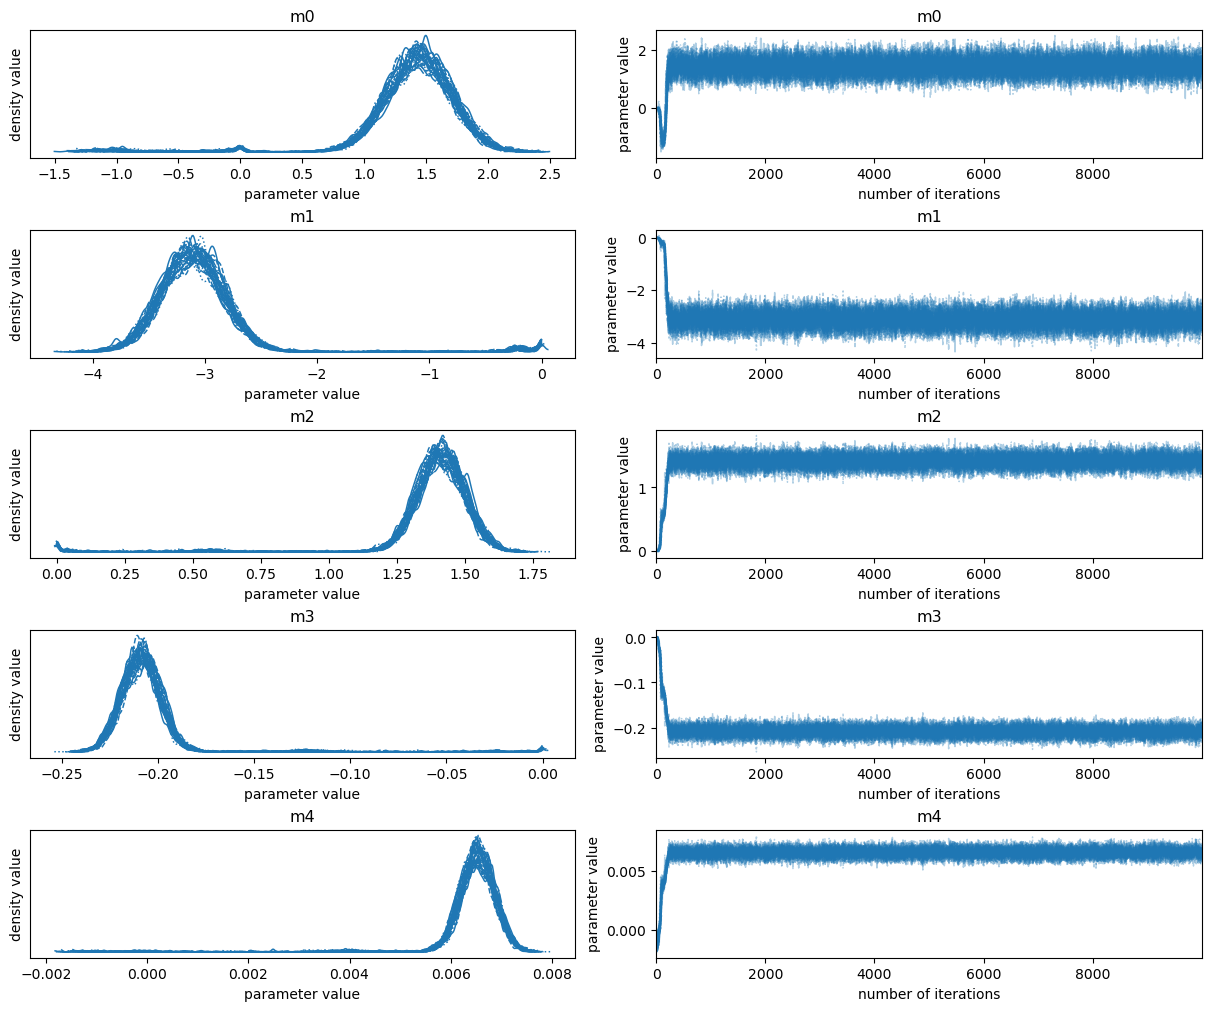

In [33]:
# a standard `trace` plot
axes = az.plot_trace(az_idata, backend_kwargs={"constrained_layout":True}); 

# add legends
for i, axes_pair in enumerate(axes):
    ax1 = axes_pair[0]
    ax2 = axes_pair[1]
    #ax1.axvline(true_model[i], linestyle='dotted', color='red')
    ax1.set_xlabel("parameter value")
    ax1.set_ylabel("density value")
    ax2.set_xlabel("number of iterations")
    ax2.set_ylabel("parameter value")

In [34]:
#tau = sampler.get_autocorr_time()
#print(f"autocorrelation time: {tau}")

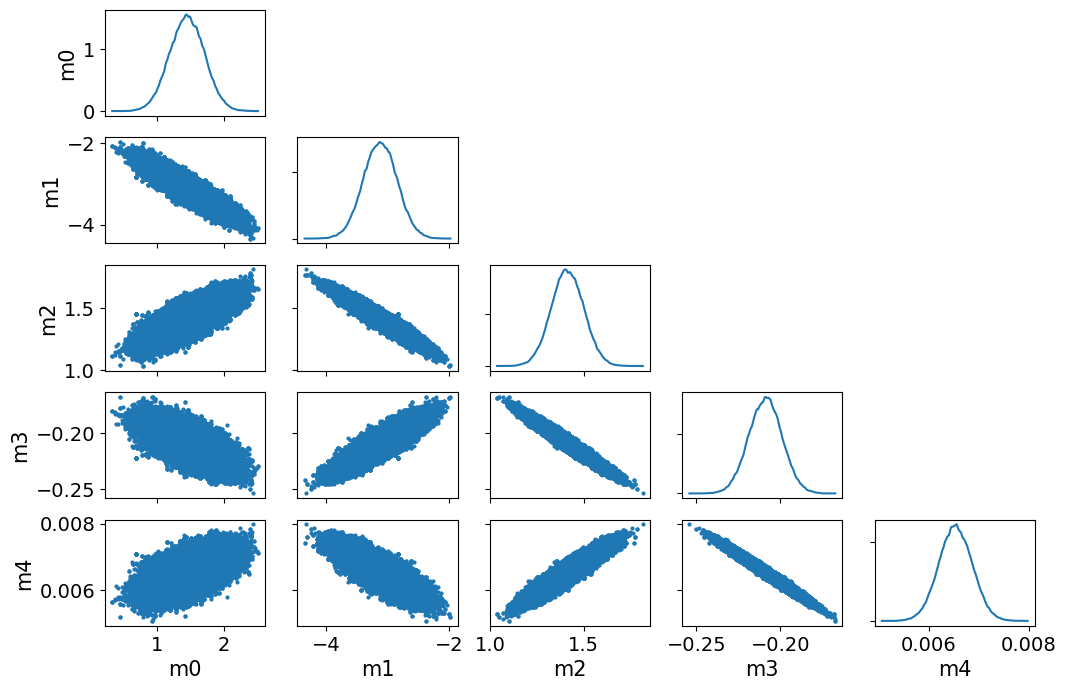

In [35]:
# a Corner plot

fig, axes = plt.subplots(nparams, nparams, figsize=(12,8))

if(True): # if we are plotting the model ensemble use this
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        ax=axes,
    );
else: # if we wish to plot a kernel density plot then use this option
    az.plot_pair(
        az_idata.sel(draw=slice(300,None)), 
        marginals=True, 
        #reference_values=dict(zip([f"m{i}" for i in range(4)], true_model.tolist())),
        kind="kde",
        kde_kwargs={
            "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
            "contourf_kwargs": {"cmap": "Blues"},
        },
        ax=axes,
    );

Now we plot the predicted curves for the posterior ensemble of solutions.

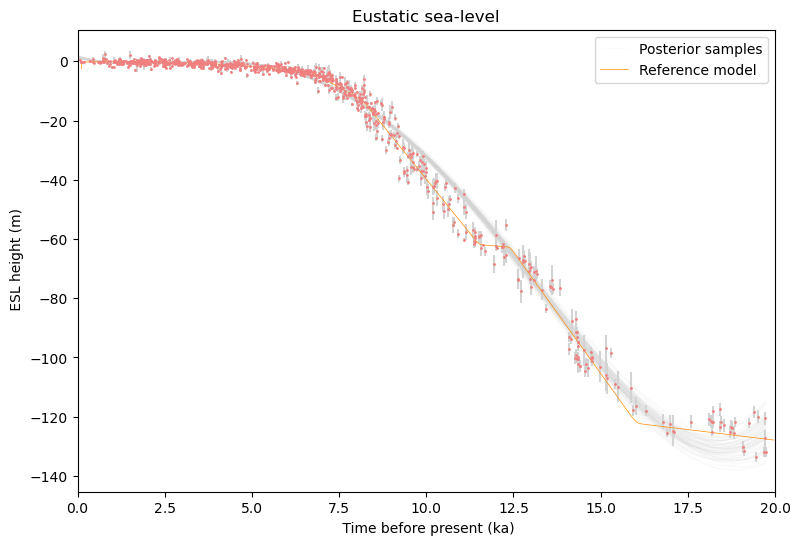

In [36]:
flat_samples = sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

plot_data(title="Eustatic sea-level")
plt.xlim(0,maxtime)
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x,ref_y, "Reference model", color="darkorange")
#plt.xlim(15,20.)
#plt.ylim(-140,-100)

#### Expected values, credible intervals and model covariance matrix from the ensemble

In [37]:
print("\n Expected value and 95% credible intervals ")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    print(" {} {:7.3f} [{:7.3f}, {:7.3f}]".format(labels[i],mcmc[1],mcmc[0],mcmc[2]))


 Expected value and 95% credible intervals 
 m0   1.447 [  1.020,   1.875]
 m1  -3.117 [ -3.572,  -2.664]
 m2   1.413 [  1.270,   1.558]
 m3  -0.209 [ -0.226,  -0.193]
 m4   0.007 [  0.006,   0.007]


In [38]:
CMpost = np.cov(flat_samples.T)
CM_std= np.std(flat_samples,axis=0)
print('Posterior model covariance matrix\n',CMpost)
print('\n Posterior estimate of model standard deviations in each parameter')
for i in range(ndim):
    print("    {} {:7.4f}".format(labels[i],CM_std[i]))

Posterior model covariance matrix
 [[ 6.76943182e-02 -6.39496924e-02  1.71443408e-02 -1.65850149e-03
   4.94509851e-05]
 [-6.39496924e-02  7.63291166e-02 -2.30426873e-02  2.40003407e-03
  -7.46247804e-05]
 [ 1.71443408e-02 -2.30426873e-02  7.61211208e-03 -8.44972205e-04
   2.72654226e-05]
 [-1.65850149e-03  2.40003407e-03 -8.44972205e-04  9.86374772e-05
  -3.28438359e-06]
 [ 4.94509851e-05 -7.46247804e-05  2.72654226e-05 -3.28438359e-06
   1.12149771e-07]]

 Posterior estimate of model standard deviations in each parameter
    m0  0.2602
    m1  0.2763
    m2  0.0872
    m3  0.0099
    m4  0.0003


---------

### Challenge - Change the prior model bounds

Replace the previous prior bounds to new values

The original  uniform bounds had  

${\mathbf l}^T = (-10.,-10.,-10.,-10.)$, and ${\mathbf u}^T = (10.,10.,10.,10.)$.

Lets replace with

${\mathbf l}^T = (-0.5,-10.,-10.,-10.)$, and ${\mathbf u}^T = (0.5,10.,10.,10.)$.

We have only changed the bounds of the first parameter. However since the true value of constant term was 6, these bounds are now inconsistent with the true model.

What does this do to the posterior distribution?

Start from the code template below:

```
m_lower_bound = <CHANGE ME>             # lower bound for uniform prior
m_upper_bound = <CHANGE ME>             # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of <CHANGE ME>, upper bounds of <CHANGE ME>")
plot_data()
plot_models(flat_samples[inds])
plot_model(x, true_y, "True model", color="darkorange")
```

In [39]:
# Copy the template above, Replace <CHANGE ME> with your answer



  0%|                                                                                                                                           | 0/10000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                | 14/10000 [00:00<01:15, 132.43it/s]

  0%|▎                                                                                                                                | 28/10000 [00:00<01:13, 135.27it/s]

  0%|▌                                                                                                                                | 43/10000 [00:00<01:12, 137.57it/s]

  1%|▋                                                                                                                                | 57/10000 [00:00<01:12, 138.00it/s]

  1%|▉                                                                                                                                | 72/10000 [00:00<01:11, 138.92it/s]

  1%|█                                                                                                                                | 86/10000 [00:00<01:11, 139.04it/s]

  1%|█▎                                                                                                                              | 101/10000 [00:00<01:10, 139.42it/s]

  1%|█▍                                                                                                                              | 115/10000 [00:00<01:10, 139.57it/s]

  1%|█▋                                                                                                                              | 130/10000 [00:00<01:10, 139.86it/s]

  1%|█▊                                                                                                                              | 145/10000 [00:01<01:10, 139.96it/s]

  2%|██                                                                                                                              | 160/10000 [00:01<01:10, 140.10it/s]

  2%|██▏                                                                                                                             | 175/10000 [00:01<01:10, 140.14it/s]

  2%|██▍                                                                                                                             | 190/10000 [00:01<01:09, 140.24it/s]

  2%|██▌                                                                                                                             | 205/10000 [00:01<01:09, 140.17it/s]

  2%|██▊                                                                                                                             | 220/10000 [00:01<01:10, 138.39it/s]

  2%|██▉                                                                                                                             | 234/10000 [00:01<01:11, 136.97it/s]

  2%|███▏                                                                                                                            | 249/10000 [00:01<01:10, 138.06it/s]

  3%|███▍                                                                                                                            | 264/10000 [00:01<01:10, 138.80it/s]

  3%|███▌                                                                                                                            | 279/10000 [00:02<01:09, 139.36it/s]

  3%|███▊                                                                                                                            | 293/10000 [00:02<01:09, 139.25it/s]

  3%|███▉                                                                                                                            | 308/10000 [00:02<01:09, 139.58it/s]

  3%|████                                                                                                                            | 322/10000 [00:02<01:09, 139.68it/s]

  3%|████▎                                                                                                                           | 336/10000 [00:02<01:21, 118.59it/s]

  4%|████▍                                                                                                                           | 351/10000 [00:02<01:18, 122.88it/s]

  4%|████▋                                                                                                                           | 366/10000 [00:02<01:15, 127.80it/s]

  4%|████▉                                                                                                                           | 381/10000 [00:02<01:13, 131.48it/s]

  4%|█████                                                                                                                           | 395/10000 [00:02<01:12, 133.20it/s]

  4%|█████▏                                                                                                                          | 410/10000 [00:03<01:10, 135.45it/s]

  4%|█████▍                                                                                                                          | 424/10000 [00:03<01:11, 134.72it/s]

  4%|█████▌                                                                                                                          | 438/10000 [00:03<01:10, 136.19it/s]

  5%|█████▊                                                                                                                          | 453/10000 [00:03<01:09, 137.41it/s]

  5%|█████▉                                                                                                                          | 467/10000 [00:03<01:09, 136.38it/s]

  5%|██████▏                                                                                                                         | 482/10000 [00:03<01:09, 137.54it/s]

  5%|██████▎                                                                                                                         | 497/10000 [00:03<01:08, 138.47it/s]

  5%|██████▌                                                                                                                         | 512/10000 [00:03<01:08, 139.04it/s]

  5%|██████▋                                                                                                                         | 527/10000 [00:03<01:07, 139.57it/s]

  5%|██████▉                                                                                                                         | 542/10000 [00:03<01:07, 139.86it/s]

  6%|███████▏                                                                                                                        | 557/10000 [00:04<01:07, 140.11it/s]

  6%|███████▎                                                                                                                        | 572/10000 [00:04<01:07, 140.23it/s]

  6%|███████▌                                                                                                                        | 587/10000 [00:04<01:08, 136.77it/s]

  6%|███████▋                                                                                                                        | 601/10000 [00:04<01:08, 137.47it/s]

  6%|███████▉                                                                                                                        | 616/10000 [00:04<01:07, 138.41it/s]

  6%|████████                                                                                                                        | 631/10000 [00:04<01:07, 139.04it/s]

  6%|████████▎                                                                                                                       | 645/10000 [00:04<01:07, 137.66it/s]

  7%|████████▍                                                                                                                       | 660/10000 [00:04<01:07, 138.45it/s]

  7%|████████▋                                                                                                                       | 675/10000 [00:04<01:07, 139.10it/s]

  7%|████████▊                                                                                                                       | 690/10000 [00:05<01:06, 139.52it/s]

  7%|█████████                                                                                                                       | 705/10000 [00:05<01:06, 139.85it/s]

  7%|█████████▏                                                                                                                      | 720/10000 [00:05<01:06, 140.02it/s]

  7%|█████████▍                                                                                                                      | 735/10000 [00:05<01:06, 140.16it/s]

  8%|█████████▌                                                                                                                      | 750/10000 [00:05<01:05, 140.26it/s]

  8%|█████████▊                                                                                                                      | 765/10000 [00:05<01:05, 140.31it/s]

  8%|█████████▉                                                                                                                      | 780/10000 [00:05<01:06, 138.29it/s]

  8%|██████████▏                                                                                                                     | 795/10000 [00:05<01:06, 138.94it/s]

  8%|██████████▎                                                                                                                     | 810/10000 [00:05<01:06, 139.18it/s]

  8%|██████████▌                                                                                                                     | 824/10000 [00:06<01:12, 126.85it/s]

  8%|██████████▋                                                                                                                     | 839/10000 [00:06<01:10, 130.71it/s]

  9%|██████████▉                                                                                                                     | 854/10000 [00:06<01:08, 133.46it/s]

  9%|███████████                                                                                                                     | 868/10000 [00:06<01:07, 135.22it/s]

  9%|███████████▎                                                                                                                    | 883/10000 [00:06<01:06, 136.76it/s]

  9%|███████████▍                                                                                                                    | 898/10000 [00:06<01:06, 137.89it/s]

  9%|███████████▋                                                                                                                    | 912/10000 [00:06<01:05, 138.35it/s]

  9%|███████████▊                                                                                                                    | 927/10000 [00:06<01:05, 138.94it/s]

  9%|████████████                                                                                                                    | 942/10000 [00:06<01:04, 139.42it/s]

 10%|████████████▏                                                                                                                   | 957/10000 [00:06<01:04, 139.71it/s]

 10%|████████████▍                                                                                                                   | 972/10000 [00:07<01:04, 139.89it/s]

 10%|████████████▌                                                                                                                   | 986/10000 [00:07<01:04, 139.89it/s]

 10%|████████████▋                                                                                                                  | 1001/10000 [00:07<01:04, 140.00it/s]

 10%|████████████▉                                                                                                                  | 1016/10000 [00:07<01:04, 140.07it/s]

 10%|█████████████                                                                                                                  | 1031/10000 [00:07<01:03, 140.17it/s]

 10%|█████████████▎                                                                                                                 | 1046/10000 [00:07<01:03, 140.11it/s]

 11%|█████████████▍                                                                                                                 | 1061/10000 [00:07<01:04, 137.96it/s]

 11%|█████████████▋                                                                                                                 | 1075/10000 [00:07<01:04, 137.84it/s]

 11%|█████████████▊                                                                                                                 | 1089/10000 [00:07<01:04, 138.45it/s]

 11%|██████████████                                                                                                                 | 1104/10000 [00:08<01:04, 138.99it/s]

 11%|██████████████▏                                                                                                                | 1119/10000 [00:08<01:03, 139.47it/s]

 11%|██████████████▍                                                                                                                | 1134/10000 [00:08<01:03, 139.79it/s]

 11%|██████████████▌                                                                                                                | 1149/10000 [00:08<01:03, 140.06it/s]

 12%|██████████████▊                                                                                                                | 1164/10000 [00:08<01:03, 140.11it/s]

 12%|██████████████▉                                                                                                                | 1179/10000 [00:08<01:02, 140.20it/s]

 12%|███████████████▏                                                                                                               | 1194/10000 [00:08<01:02, 140.21it/s]

 12%|███████████████▎                                                                                                               | 1209/10000 [00:08<01:02, 140.31it/s]

 12%|███████████████▌                                                                                                               | 1224/10000 [00:08<01:02, 140.36it/s]

 12%|███████████████▋                                                                                                               | 1239/10000 [00:08<01:02, 140.47it/s]

 13%|███████████████▉                                                                                                               | 1254/10000 [00:09<01:02, 140.51it/s]

 13%|████████████████                                                                                                               | 1269/10000 [00:09<01:02, 140.47it/s]

 13%|████████████████▎                                                                                                              | 1284/10000 [00:09<01:02, 140.45it/s]

 13%|████████████████▍                                                                                                              | 1299/10000 [00:09<01:01, 140.49it/s]

 13%|████████████████▋                                                                                                              | 1314/10000 [00:09<01:01, 140.49it/s]

 13%|████████████████▉                                                                                                              | 1329/10000 [00:09<01:01, 140.39it/s]

 13%|█████████████████                                                                                                              | 1344/10000 [00:09<01:01, 140.40it/s]

 14%|█████████████████▎                                                                                                             | 1359/10000 [00:09<01:01, 140.49it/s]

 14%|█████████████████▍                                                                                                             | 1374/10000 [00:09<01:01, 140.52it/s]

 14%|█████████████████▋                                                                                                             | 1389/10000 [00:10<01:01, 140.52it/s]

 14%|█████████████████▊                                                                                                             | 1404/10000 [00:10<01:01, 140.51it/s]

 14%|██████████████████                                                                                                             | 1419/10000 [00:10<01:01, 140.55it/s]

 14%|██████████████████▏                                                                                                            | 1434/10000 [00:10<01:00, 140.55it/s]

 14%|██████████████████▍                                                                                                            | 1449/10000 [00:10<01:00, 140.48it/s]

 15%|██████████████████▌                                                                                                            | 1464/10000 [00:10<01:00, 140.32it/s]

 15%|██████████████████▊                                                                                                            | 1479/10000 [00:10<01:01, 138.62it/s]

 15%|██████████████████▉                                                                                                            | 1493/10000 [00:10<01:01, 138.95it/s]

 15%|███████████████████▏                                                                                                           | 1508/10000 [00:10<01:00, 139.36it/s]

 15%|███████████████████▎                                                                                                           | 1523/10000 [00:11<01:00, 139.66it/s]

 15%|███████████████████▌                                                                                                           | 1538/10000 [00:11<01:00, 139.87it/s]

 16%|███████████████████▋                                                                                                           | 1553/10000 [00:11<01:00, 140.05it/s]

 16%|███████████████████▉                                                                                                           | 1568/10000 [00:11<01:00, 140.05it/s]

 16%|████████████████████                                                                                                           | 1583/10000 [00:11<01:00, 140.14it/s]

 16%|████████████████████▎                                                                                                          | 1598/10000 [00:11<00:59, 140.23it/s]

 16%|████████████████████▍                                                                                                          | 1613/10000 [00:11<00:59, 140.19it/s]

 16%|████████████████████▋                                                                                                          | 1628/10000 [00:11<00:59, 140.27it/s]

 16%|████████████████████▊                                                                                                          | 1643/10000 [00:11<00:59, 140.35it/s]

 17%|█████████████████████                                                                                                          | 1658/10000 [00:11<00:59, 140.43it/s]

 17%|█████████████████████▏                                                                                                         | 1673/10000 [00:12<00:59, 140.41it/s]

 17%|█████████████████████▍                                                                                                         | 1688/10000 [00:12<00:59, 140.31it/s]

 17%|█████████████████████▋                                                                                                         | 1703/10000 [00:12<00:59, 140.19it/s]

 17%|█████████████████████▊                                                                                                         | 1718/10000 [00:12<00:59, 140.28it/s]

 17%|██████████████████████                                                                                                         | 1733/10000 [00:12<00:58, 140.25it/s]

 17%|██████████████████████▏                                                                                                        | 1748/10000 [00:12<00:58, 140.20it/s]

 18%|██████████████████████▍                                                                                                        | 1763/10000 [00:12<00:58, 139.99it/s]

 18%|██████████████████████▌                                                                                                        | 1777/10000 [00:12<00:59, 139.23it/s]

 18%|██████████████████████▋                                                                                                        | 1791/10000 [00:12<00:58, 139.43it/s]

 18%|██████████████████████▉                                                                                                        | 1806/10000 [00:13<00:58, 139.78it/s]

 18%|███████████████████████▏                                                                                                       | 1821/10000 [00:13<00:58, 139.99it/s]

 18%|███████████████████████▎                                                                                                       | 1836/10000 [00:13<00:58, 140.18it/s]

 19%|███████████████████████▌                                                                                                       | 1851/10000 [00:13<00:58, 140.13it/s]

 19%|███████████████████████▋                                                                                                       | 1866/10000 [00:13<00:58, 140.21it/s]

 19%|███████████████████████▉                                                                                                       | 1881/10000 [00:13<00:57, 140.24it/s]

 19%|████████████████████████                                                                                                       | 1896/10000 [00:13<00:58, 138.34it/s]

 19%|████████████████████████▎                                                                                                      | 1910/10000 [00:13<00:58, 138.81it/s]

 19%|████████████████████████▍                                                                                                      | 1924/10000 [00:13<00:58, 138.92it/s]

 19%|████████████████████████▋                                                                                                      | 1939/10000 [00:13<00:57, 139.40it/s]

 20%|████████████████████████▊                                                                                                      | 1954/10000 [00:14<00:57, 139.70it/s]

 20%|█████████████████████████                                                                                                      | 1969/10000 [00:14<00:57, 139.26it/s]

 20%|█████████████████████████▏                                                                                                     | 1984/10000 [00:14<00:57, 139.66it/s]

 20%|█████████████████████████▎                                                                                                     | 1998/10000 [00:14<00:57, 139.53it/s]

 20%|█████████████████████████▌                                                                                                     | 2013/10000 [00:14<00:57, 139.79it/s]

 20%|█████████████████████████▋                                                                                                     | 2027/10000 [00:14<00:57, 137.75it/s]

 20%|█████████████████████████▉                                                                                                     | 2041/10000 [00:14<01:00, 132.25it/s]

 21%|██████████████████████████                                                                                                     | 2055/10000 [00:14<01:04, 123.25it/s]

 21%|██████████████████████████▎                                                                                                    | 2068/10000 [00:14<01:07, 117.25it/s]

 21%|██████████████████████████▍                                                                                                    | 2082/10000 [00:15<01:04, 123.21it/s]

 21%|██████████████████████████▋                                                                                                    | 2097/10000 [00:15<01:01, 128.16it/s]

 21%|██████████████████████████▊                                                                                                    | 2112/10000 [00:15<00:59, 131.70it/s]

 21%|███████████████████████████                                                                                                    | 2127/10000 [00:15<00:58, 134.28it/s]

 21%|███████████████████████████▏                                                                                                   | 2142/10000 [00:15<00:57, 136.07it/s]

 22%|███████████████████████████▍                                                                                                   | 2157/10000 [00:15<00:57, 137.28it/s]

 22%|███████████████████████████▌                                                                                                   | 2171/10000 [00:15<00:57, 136.14it/s]

 22%|███████████████████████████▊                                                                                                   | 2186/10000 [00:15<00:56, 137.45it/s]

 22%|███████████████████████████▉                                                                                                   | 2200/10000 [00:15<00:57, 136.07it/s]

 22%|████████████████████████████▏                                                                                                  | 2215/10000 [00:16<00:56, 137.29it/s]

 22%|████████████████████████████▎                                                                                                  | 2230/10000 [00:16<00:56, 138.22it/s]

 22%|████████████████████████████▍                                                                                                  | 2244/10000 [00:16<00:55, 138.68it/s]

 23%|████████████████████████████▋                                                                                                  | 2259/10000 [00:16<00:55, 139.22it/s]

 23%|████████████████████████████▉                                                                                                  | 2274/10000 [00:16<00:55, 139.50it/s]

 23%|█████████████████████████████                                                                                                  | 2289/10000 [00:16<00:55, 139.79it/s]

 23%|█████████████████████████████▏                                                                                                 | 2303/10000 [00:16<00:55, 137.90it/s]

 23%|█████████████████████████████▍                                                                                                 | 2318/10000 [00:16<00:55, 138.68it/s]

 23%|█████████████████████████████▌                                                                                                 | 2332/10000 [00:16<00:55, 139.04it/s]

 23%|█████████████████████████████▊                                                                                                 | 2347/10000 [00:17<00:54, 139.51it/s]

 24%|█████████████████████████████▉                                                                                                 | 2362/10000 [00:17<00:54, 139.78it/s]

 24%|██████████████████████████████▏                                                                                                | 2377/10000 [00:17<00:54, 139.96it/s]

 24%|██████████████████████████████▍                                                                                                | 2392/10000 [00:17<00:55, 138.32it/s]

 24%|██████████████████████████████▌                                                                                                | 2407/10000 [00:17<00:54, 139.01it/s]

 24%|██████████████████████████████▊                                                                                                | 2422/10000 [00:17<00:54, 139.37it/s]

 24%|██████████████████████████████▉                                                                                                | 2436/10000 [00:17<00:54, 139.50it/s]

 25%|███████████████████████████████▏                                                                                               | 2451/10000 [00:17<00:54, 139.71it/s]

 25%|███████████████████████████████▎                                                                                               | 2465/10000 [00:17<00:54, 139.23it/s]

 25%|███████████████████████████████▍                                                                                               | 2480/10000 [00:17<00:53, 139.52it/s]

 25%|███████████████████████████████▋                                                                                               | 2494/10000 [00:18<00:53, 139.62it/s]

 25%|███████████████████████████████▊                                                                                               | 2508/10000 [00:18<00:53, 139.72it/s]

 25%|████████████████████████████████                                                                                               | 2523/10000 [00:18<00:53, 140.02it/s]

 25%|████████████████████████████████▏                                                                                              | 2538/10000 [00:18<00:54, 138.15it/s]

 26%|████████████████████████████████▍                                                                                              | 2553/10000 [00:18<00:53, 138.88it/s]

 26%|████████████████████████████████▌                                                                                              | 2568/10000 [00:18<00:53, 139.36it/s]

 26%|████████████████████████████████▊                                                                                              | 2583/10000 [00:18<00:53, 139.67it/s]

 26%|████████████████████████████████▉                                                                                              | 2598/10000 [00:18<00:52, 139.86it/s]

 26%|█████████████████████████████████▏                                                                                             | 2613/10000 [00:18<00:52, 140.11it/s]

 26%|█████████████████████████████████▍                                                                                             | 2628/10000 [00:19<00:52, 140.19it/s]

 26%|█████████████████████████████████▌                                                                                             | 2643/10000 [00:19<00:52, 140.19it/s]

 27%|█████████████████████████████████▊                                                                                             | 2658/10000 [00:19<00:52, 140.26it/s]

 27%|█████████████████████████████████▉                                                                                             | 2673/10000 [00:19<00:52, 140.33it/s]

 27%|██████████████████████████████████▏                                                                                            | 2688/10000 [00:19<00:52, 140.36it/s]

 27%|██████████████████████████████████▎                                                                                            | 2703/10000 [00:19<00:51, 140.40it/s]

 27%|██████████████████████████████████▌                                                                                            | 2718/10000 [00:19<00:52, 138.60it/s]

 27%|██████████████████████████████████▋                                                                                            | 2733/10000 [00:19<00:52, 139.13it/s]

 27%|██████████████████████████████████▉                                                                                            | 2748/10000 [00:19<00:51, 139.53it/s]

 28%|███████████████████████████████████                                                                                            | 2763/10000 [00:19<00:51, 139.82it/s]

 28%|███████████████████████████████████▎                                                                                           | 2778/10000 [00:20<00:51, 140.02it/s]

 28%|███████████████████████████████████▍                                                                                           | 2793/10000 [00:20<00:51, 140.17it/s]

 28%|███████████████████████████████████▋                                                                                           | 2808/10000 [00:20<00:51, 140.28it/s]

 28%|███████████████████████████████████▊                                                                                           | 2823/10000 [00:20<00:51, 140.37it/s]

 28%|████████████████████████████████████                                                                                           | 2838/10000 [00:20<00:51, 140.41it/s]

 29%|████████████████████████████████████▏                                                                                          | 2853/10000 [00:20<00:50, 140.28it/s]

 29%|████████████████████████████████████▍                                                                                          | 2868/10000 [00:20<00:50, 140.20it/s]

 29%|████████████████████████████████████▌                                                                                          | 2883/10000 [00:20<00:50, 140.32it/s]

 29%|████████████████████████████████████▊                                                                                          | 2898/10000 [00:20<00:50, 140.38it/s]

 29%|████████████████████████████████████▉                                                                                          | 2913/10000 [00:21<00:50, 140.34it/s]

 29%|█████████████████████████████████████▏                                                                                         | 2928/10000 [00:21<00:50, 140.37it/s]

 29%|█████████████████████████████████████▍                                                                                         | 2943/10000 [00:21<00:50, 140.43it/s]

 30%|█████████████████████████████████████▌                                                                                         | 2958/10000 [00:21<00:50, 138.56it/s]

 30%|█████████████████████████████████████▊                                                                                         | 2973/10000 [00:21<00:50, 139.07it/s]

 30%|█████████████████████████████████████▉                                                                                         | 2988/10000 [00:21<00:50, 139.45it/s]

 30%|██████████████████████████████████████▏                                                                                        | 3002/10000 [00:21<00:50, 139.60it/s]

 30%|██████████████████████████████████████▎                                                                                        | 3017/10000 [00:21<00:49, 139.89it/s]

 30%|██████████████████████████████████████▌                                                                                        | 3032/10000 [00:21<00:49, 140.09it/s]

 30%|██████████████████████████████████████▋                                                                                        | 3047/10000 [00:22<00:49, 140.21it/s]

 31%|██████████████████████████████████████▉                                                                                        | 3062/10000 [00:22<00:49, 140.15it/s]

 31%|███████████████████████████████████████                                                                                        | 3077/10000 [00:22<00:49, 140.24it/s]

 31%|███████████████████████████████████████▎                                                                                       | 3092/10000 [00:22<00:49, 140.28it/s]

 31%|███████████████████████████████████████▍                                                                                       | 3107/10000 [00:22<00:49, 140.39it/s]

 31%|███████████████████████████████████████▋                                                                                       | 3122/10000 [00:22<00:49, 140.36it/s]

 31%|███████████████████████████████████████▊                                                                                       | 3137/10000 [00:22<00:49, 138.48it/s]

 32%|████████████████████████████████████████                                                                                       | 3152/10000 [00:22<00:49, 139.09it/s]

 32%|████████████████████████████████████████▏                                                                                      | 3166/10000 [00:22<00:49, 138.68it/s]

 32%|████████████████████████████████████████▍                                                                                      | 3181/10000 [00:22<00:48, 139.24it/s]

 32%|████████████████████████████████████████▌                                                                                      | 3196/10000 [00:23<00:48, 139.55it/s]

 32%|████████████████████████████████████████▊                                                                                      | 3211/10000 [00:23<00:48, 139.81it/s]

 32%|████████████████████████████████████████▉                                                                                      | 3226/10000 [00:23<00:48, 139.98it/s]

 32%|█████████████████████████████████████████▏                                                                                     | 3241/10000 [00:23<00:48, 140.15it/s]

 33%|█████████████████████████████████████████▎                                                                                     | 3256/10000 [00:23<00:48, 140.23it/s]

 33%|█████████████████████████████████████████▌                                                                                     | 3271/10000 [00:23<00:48, 140.10it/s]

 33%|█████████████████████████████████████████▋                                                                                     | 3286/10000 [00:23<00:47, 140.17it/s]

 33%|█████████████████████████████████████████▉                                                                                     | 3301/10000 [00:23<00:47, 140.22it/s]

 33%|██████████████████████████████████████████                                                                                     | 3316/10000 [00:23<00:47, 139.93it/s]

 33%|██████████████████████████████████████████▎                                                                                    | 3331/10000 [00:24<00:47, 140.10it/s]

 33%|██████████████████████████████████████████▍                                                                                    | 3346/10000 [00:24<00:48, 138.28it/s]

 34%|██████████████████████████████████████████▋                                                                                    | 3360/10000 [00:24<00:48, 138.02it/s]

 34%|██████████████████████████████████████████▊                                                                                    | 3375/10000 [00:24<00:47, 138.79it/s]

 34%|███████████████████████████████████████████                                                                                    | 3389/10000 [00:24<00:47, 138.62it/s]

 34%|███████████████████████████████████████████▏                                                                                   | 3404/10000 [00:24<00:47, 139.11it/s]

 34%|███████████████████████████████████████████▍                                                                                   | 3418/10000 [00:24<00:47, 139.35it/s]

 34%|███████████████████████████████████████████▌                                                                                   | 3433/10000 [00:24<00:46, 139.78it/s]

 34%|███████████████████████████████████████████▊                                                                                   | 3447/10000 [00:24<00:46, 139.80it/s]

 35%|███████████████████████████████████████████▉                                                                                   | 3462/10000 [00:24<00:46, 140.00it/s]

 35%|████████████████████████████████████████████▏                                                                                  | 3476/10000 [00:25<00:46, 139.98it/s]

 35%|████████████████████████████████████████████▎                                                                                  | 3491/10000 [00:25<00:46, 140.13it/s]

 35%|████████████████████████████████████████████▌                                                                                  | 3506/10000 [00:25<00:46, 140.20it/s]

 35%|████████████████████████████████████████████▋                                                                                  | 3521/10000 [00:25<00:46, 140.30it/s]

 35%|████████████████████████████████████████████▉                                                                                  | 3536/10000 [00:25<00:46, 140.24it/s]

 36%|█████████████████████████████████████████████                                                                                  | 3551/10000 [00:25<00:45, 140.29it/s]

 36%|█████████████████████████████████████████████▎                                                                                 | 3566/10000 [00:25<00:46, 138.58it/s]

 36%|█████████████████████████████████████████████▍                                                                                 | 3581/10000 [00:25<00:46, 139.12it/s]

 36%|█████████████████████████████████████████████▋                                                                                 | 3595/10000 [00:25<00:46, 138.58it/s]

 36%|█████████████████████████████████████████████▊                                                                                 | 3609/10000 [00:26<00:46, 138.70it/s]

 36%|██████████████████████████████████████████████                                                                                 | 3623/10000 [00:26<00:45, 139.07it/s]

 36%|██████████████████████████████████████████████▏                                                                                | 3638/10000 [00:26<00:45, 139.45it/s]

 37%|██████████████████████████████████████████████▍                                                                                | 3653/10000 [00:26<00:45, 139.74it/s]

 37%|██████████████████████████████████████████████▌                                                                                | 3667/10000 [00:26<00:45, 139.80it/s]

 37%|██████████████████████████████████████████████▊                                                                                | 3682/10000 [00:26<00:45, 139.98it/s]

 37%|██████████████████████████████████████████████▉                                                                                | 3697/10000 [00:26<00:45, 140.04it/s]

 37%|███████████████████████████████████████████████▏                                                                               | 3712/10000 [00:26<00:44, 140.15it/s]

 37%|███████████████████████████████████████████████▎                                                                               | 3727/10000 [00:26<00:44, 140.25it/s]

 37%|███████████████████████████████████████████████▌                                                                               | 3742/10000 [00:26<00:44, 140.30it/s]

 38%|███████████████████████████████████████████████▋                                                                               | 3757/10000 [00:27<00:44, 140.35it/s]

 38%|███████████████████████████████████████████████▉                                                                               | 3772/10000 [00:27<00:44, 140.27it/s]

 38%|████████████████████████████████████████████████                                                                               | 3787/10000 [00:27<00:44, 140.31it/s]

 38%|████████████████████████████████████████████████▎                                                                              | 3802/10000 [00:27<00:44, 140.41it/s]

 38%|████████████████████████████████████████████████▍                                                                              | 3817/10000 [00:27<00:44, 140.44it/s]

 38%|████████████████████████████████████████████████▋                                                                              | 3832/10000 [00:27<00:43, 140.38it/s]

 38%|████████████████████████████████████████████████▊                                                                              | 3847/10000 [00:27<00:43, 140.41it/s]

 39%|█████████████████████████████████████████████████                                                                              | 3862/10000 [00:27<00:43, 139.71it/s]

 39%|█████████████████████████████████████████████████▏                                                                             | 3877/10000 [00:27<00:43, 139.90it/s]

 39%|█████████████████████████████████████████████████▍                                                                             | 3891/10000 [00:28<00:44, 138.00it/s]

 39%|█████████████████████████████████████████████████▌                                                                             | 3906/10000 [00:28<00:43, 138.75it/s]

 39%|█████████████████████████████████████████████████▊                                                                             | 3921/10000 [00:28<00:43, 139.20it/s]

 39%|█████████████████████████████████████████████████▉                                                                             | 3936/10000 [00:28<00:43, 139.67it/s]

 40%|██████████████████████████████████████████████████▏                                                                            | 3951/10000 [00:28<00:43, 139.90it/s]

 40%|██████████████████████████████████████████████████▎                                                                            | 3966/10000 [00:28<00:43, 140.01it/s]

 40%|██████████████████████████████████████████████████▌                                                                            | 3981/10000 [00:28<00:43, 138.23it/s]

 40%|██████████████████████████████████████████████████▋                                                                            | 3996/10000 [00:28<00:43, 138.90it/s]

 40%|██████████████████████████████████████████████████▉                                                                            | 4011/10000 [00:28<00:42, 139.36it/s]

 40%|███████████████████████████████████████████████████                                                                            | 4025/10000 [00:29<00:43, 138.71it/s]

 40%|███████████████████████████████████████████████████▎                                                                           | 4040/10000 [00:29<00:42, 139.14it/s]

 41%|███████████████████████████████████████████████████▍                                                                           | 4055/10000 [00:29<00:42, 139.49it/s]

 41%|███████████████████████████████████████████████████▋                                                                           | 4070/10000 [00:29<00:42, 139.78it/s]

 41%|███████████████████████████████████████████████████▉                                                                           | 4085/10000 [00:29<00:42, 140.05it/s]

 41%|████████████████████████████████████████████████████                                                                           | 4100/10000 [00:29<00:42, 140.13it/s]

 41%|████████████████████████████████████████████████████▎                                                                          | 4115/10000 [00:29<00:42, 140.07it/s]

 41%|████████████████████████████████████████████████████▍                                                                          | 4130/10000 [00:29<00:41, 140.07it/s]

 41%|████████████████████████████████████████████████████▋                                                                          | 4145/10000 [00:29<00:41, 140.11it/s]

 42%|████████████████████████████████████████████████████▊                                                                          | 4160/10000 [00:29<00:41, 140.22it/s]

 42%|█████████████████████████████████████████████████████                                                                          | 4175/10000 [00:30<00:52, 110.47it/s]

 42%|█████████████████████████████████████████████████████▏                                                                         | 4189/10000 [00:30<00:50, 115.91it/s]

 42%|█████████████████████████████████████████████████████▍                                                                         | 4203/10000 [00:30<00:48, 120.55it/s]

 42%|█████████████████████████████████████████████████████▌                                                                         | 4217/10000 [00:30<00:46, 125.53it/s]

 42%|█████████████████████████████████████████████████████▋                                                                         | 4232/10000 [00:30<00:44, 129.78it/s]

 42%|█████████████████████████████████████████████████████▉                                                                         | 4247/10000 [00:30<00:43, 132.79it/s]

 43%|██████████████████████████████████████████████████████▏                                                                        | 4262/10000 [00:30<00:42, 134.96it/s]

 43%|██████████████████████████████████████████████████████▎                                                                        | 4276/10000 [00:30<00:42, 136.25it/s]

 43%|██████████████████████████████████████████████████████▍                                                                        | 4290/10000 [00:31<00:41, 137.32it/s]

 43%|██████████████████████████████████████████████████████▋                                                                        | 4304/10000 [00:31<00:41, 138.04it/s]

 43%|██████████████████████████████████████████████████████▊                                                                        | 4318/10000 [00:31<00:40, 138.59it/s]

 43%|███████████████████████████████████████████████████████                                                                        | 4332/10000 [00:31<00:41, 137.07it/s]

 43%|███████████████████████████████████████████████████████▏                                                                       | 4347/10000 [00:31<00:40, 138.09it/s]

 44%|███████████████████████████████████████████████████████▍                                                                       | 4361/10000 [00:31<00:40, 138.63it/s]

 44%|███████████████████████████████████████████████████████▌                                                                       | 4376/10000 [00:31<00:40, 139.08it/s]

 44%|███████████████████████████████████████████████████████▊                                                                       | 4390/10000 [00:31<00:40, 137.59it/s]

 44%|███████████████████████████████████████████████████████▉                                                                       | 4405/10000 [00:31<00:40, 138.39it/s]

 44%|████████████████████████████████████████████████████████▏                                                                      | 4420/10000 [00:31<00:40, 139.03it/s]

 44%|████████████████████████████████████████████████████████▎                                                                      | 4435/10000 [00:32<00:39, 139.37it/s]

 44%|████████████████████████████████████████████████████████▌                                                                      | 4450/10000 [00:32<00:39, 139.62it/s]

 45%|████████████████████████████████████████████████████████▋                                                                      | 4465/10000 [00:32<00:39, 139.92it/s]

 45%|████████████████████████████████████████████████████████▉                                                                      | 4480/10000 [00:32<00:39, 140.03it/s]

 45%|█████████████████████████████████████████████████████████                                                                      | 4495/10000 [00:32<00:39, 140.08it/s]

 45%|█████████████████████████████████████████████████████████▎                                                                     | 4510/10000 [00:32<00:39, 140.23it/s]

 45%|█████████████████████████████████████████████████████████▍                                                                     | 4525/10000 [00:32<00:39, 140.24it/s]

 45%|█████████████████████████████████████████████████████████▋                                                                     | 4540/10000 [00:32<00:39, 139.59it/s]

 46%|█████████████████████████████████████████████████████████▊                                                                     | 4555/10000 [00:32<00:38, 139.80it/s]

 46%|██████████████████████████████████████████████████████████                                                                     | 4570/10000 [00:33<00:38, 139.95it/s]

 46%|██████████████████████████████████████████████████████████▏                                                                    | 4585/10000 [00:33<00:38, 140.05it/s]

 46%|██████████████████████████████████████████████████████████▍                                                                    | 4600/10000 [00:33<00:38, 140.11it/s]

 46%|██████████████████████████████████████████████████████████▌                                                                    | 4615/10000 [00:33<00:38, 140.11it/s]

 46%|██████████████████████████████████████████████████████████▊                                                                    | 4630/10000 [00:33<00:38, 140.21it/s]

 46%|██████████████████████████████████████████████████████████▉                                                                    | 4645/10000 [00:33<00:38, 140.34it/s]

 47%|███████████████████████████████████████████████████████████▏                                                                   | 4660/10000 [00:33<00:38, 140.36it/s]

 47%|███████████████████████████████████████████████████████████▎                                                                   | 4675/10000 [00:33<00:37, 140.43it/s]

 47%|███████████████████████████████████████████████████████████▌                                                                   | 4690/10000 [00:33<00:37, 140.44it/s]

 47%|███████████████████████████████████████████████████████████▊                                                                   | 4705/10000 [00:33<00:37, 140.43it/s]

 47%|███████████████████████████████████████████████████████████▉                                                                   | 4720/10000 [00:34<00:37, 140.48it/s]

 47%|████████████████████████████████████████████████████████████▏                                                                  | 4735/10000 [00:34<00:37, 140.36it/s]

 48%|████████████████████████████████████████████████████████████▎                                                                  | 4750/10000 [00:34<00:37, 140.22it/s]

 48%|████████████████████████████████████████████████████████████▌                                                                  | 4765/10000 [00:34<00:37, 137.98it/s]

 48%|████████████████████████████████████████████████████████████▋                                                                  | 4780/10000 [00:34<00:37, 138.69it/s]

 48%|████████████████████████████████████████████████████████████▉                                                                  | 4795/10000 [00:34<00:37, 139.07it/s]

 48%|█████████████████████████████████████████████████████████████                                                                  | 4809/10000 [00:34<00:37, 137.67it/s]

 48%|█████████████████████████████████████████████████████████████▎                                                                 | 4824/10000 [00:34<00:37, 138.48it/s]

 48%|█████████████████████████████████████████████████████████████▍                                                                 | 4839/10000 [00:34<00:37, 139.15it/s]

 49%|█████████████████████████████████████████████████████████████▋                                                                 | 4854/10000 [00:35<00:36, 139.53it/s]

 49%|█████████████████████████████████████████████████████████████▊                                                                 | 4869/10000 [00:35<00:36, 139.73it/s]

 49%|██████████████████████████████████████████████████████████████                                                                 | 4883/10000 [00:35<00:36, 139.80it/s]

 49%|██████████████████████████████████████████████████████████████▏                                                                | 4898/10000 [00:35<00:36, 139.99it/s]

 49%|██████████████████████████████████████████████████████████████▍                                                                | 4913/10000 [00:35<00:36, 140.09it/s]

 49%|██████████████████████████████████████████████████████████████▌                                                                | 4928/10000 [00:35<00:36, 140.14it/s]

 49%|██████████████████████████████████████████████████████████████▊                                                                | 4943/10000 [00:35<00:36, 139.99it/s]

 50%|██████████████████████████████████████████████████████████████▉                                                                | 4958/10000 [00:35<00:35, 140.14it/s]

 50%|███████████████████████████████████████████████████████████████▏                                                               | 4973/10000 [00:35<00:35, 140.23it/s]

 50%|███████████████████████████████████████████████████████████████▎                                                               | 4988/10000 [00:36<00:35, 140.27it/s]

 50%|███████████████████████████████████████████████████████████████▌                                                               | 5003/10000 [00:36<00:35, 140.31it/s]

 50%|███████████████████████████████████████████████████████████████▋                                                               | 5018/10000 [00:36<00:35, 140.26it/s]

 50%|███████████████████████████████████████████████████████████████▉                                                               | 5033/10000 [00:36<00:35, 140.31it/s]

 50%|████████████████████████████████████████████████████████████████                                                               | 5048/10000 [00:36<00:35, 140.39it/s]

 51%|████████████████████████████████████████████████████████████████▎                                                              | 5063/10000 [00:36<00:35, 140.38it/s]

 51%|████████████████████████████████████████████████████████████████▍                                                              | 5078/10000 [00:36<00:35, 140.45it/s]

 51%|████████████████████████████████████████████████████████████████▋                                                              | 5093/10000 [00:36<00:34, 140.45it/s]

 51%|████████████████████████████████████████████████████████████████▊                                                              | 5108/10000 [00:36<00:34, 140.41it/s]

 51%|█████████████████████████████████████████████████████████████████                                                              | 5123/10000 [00:36<00:34, 140.41it/s]

 51%|█████████████████████████████████████████████████████████████████▎                                                             | 5138/10000 [00:37<00:34, 140.44it/s]

 52%|█████████████████████████████████████████████████████████████████▍                                                             | 5153/10000 [00:37<00:34, 140.39it/s]

 52%|█████████████████████████████████████████████████████████████████▋                                                             | 5168/10000 [00:37<00:34, 140.39it/s]

 52%|█████████████████████████████████████████████████████████████████▊                                                             | 5183/10000 [00:37<00:34, 140.47it/s]

 52%|██████████████████████████████████████████████████████████████████                                                             | 5198/10000 [00:37<00:34, 140.50it/s]

 52%|██████████████████████████████████████████████████████████████████▏                                                            | 5213/10000 [00:37<00:34, 140.52it/s]

 52%|██████████████████████████████████████████████████████████████████▍                                                            | 5228/10000 [00:37<00:34, 138.67it/s]

 52%|██████████████████████████████████████████████████████████████████▌                                                            | 5242/10000 [00:37<00:34, 138.38it/s]

 53%|██████████████████████████████████████████████████████████████████▊                                                            | 5257/10000 [00:37<00:34, 138.97it/s]

 53%|██████████████████████████████████████████████████████████████████▉                                                            | 5272/10000 [00:38<00:33, 139.38it/s]

 53%|███████████████████████████████████████████████████████████████████▏                                                           | 5287/10000 [00:38<00:33, 139.66it/s]

 53%|███████████████████████████████████████████████████████████████████▎                                                           | 5302/10000 [00:38<00:33, 139.84it/s]

 53%|███████████████████████████████████████████████████████████████████▌                                                           | 5317/10000 [00:38<00:33, 140.11it/s]

 53%|███████████████████████████████████████████████████████████████████▋                                                           | 5332/10000 [00:38<00:33, 140.20it/s]

 53%|███████████████████████████████████████████████████████████████████▉                                                           | 5347/10000 [00:38<00:33, 140.16it/s]

 54%|████████████████████████████████████████████████████████████████████                                                           | 5362/10000 [00:38<00:33, 140.16it/s]

 54%|████████████████████████████████████████████████████████████████████▎                                                          | 5377/10000 [00:38<00:32, 140.31it/s]

 54%|████████████████████████████████████████████████████████████████████▍                                                          | 5392/10000 [00:38<00:32, 140.37it/s]

 54%|████████████████████████████████████████████████████████████████████▋                                                          | 5407/10000 [00:39<00:32, 140.38it/s]

 54%|████████████████████████████████████████████████████████████████████▊                                                          | 5422/10000 [00:39<00:32, 140.42it/s]

 54%|█████████████████████████████████████████████████████████████████████                                                          | 5437/10000 [00:39<00:32, 140.50it/s]

 55%|█████████████████████████████████████████████████████████████████████▏                                                         | 5452/10000 [00:39<00:32, 140.53it/s]

 55%|█████████████████████████████████████████████████████████████████████▍                                                         | 5467/10000 [00:39<00:32, 140.51it/s]

 55%|█████████████████████████████████████████████████████████████████████▌                                                         | 5482/10000 [00:39<00:32, 140.50it/s]

 55%|█████████████████████████████████████████████████████████████████████▊                                                         | 5497/10000 [00:39<00:32, 140.44it/s]

 55%|██████████████████████████████████████████████████████████████████████                                                         | 5512/10000 [00:39<00:31, 140.46it/s]

 55%|██████████████████████████████████████████████████████████████████████▏                                                        | 5527/10000 [00:39<00:31, 140.44it/s]

 55%|██████████████████████████████████████████████████████████████████████▍                                                        | 5542/10000 [00:39<00:31, 140.45it/s]

 56%|██████████████████████████████████████████████████████████████████████▌                                                        | 5557/10000 [00:40<00:31, 140.49it/s]

 56%|██████████████████████████████████████████████████████████████████████▊                                                        | 5572/10000 [00:40<00:31, 140.45it/s]

 56%|██████████████████████████████████████████████████████████████████████▉                                                        | 5587/10000 [00:40<00:31, 140.47it/s]

 56%|███████████████████████████████████████████████████████████████████████▏                                                       | 5602/10000 [00:40<00:31, 140.50it/s]

 56%|███████████████████████████████████████████████████████████████████████▎                                                       | 5617/10000 [00:40<00:31, 140.49it/s]

 56%|███████████████████████████████████████████████████████████████████████▌                                                       | 5632/10000 [00:40<00:31, 140.55it/s]

 56%|███████████████████████████████████████████████████████████████████████▋                                                       | 5647/10000 [00:40<00:31, 138.72it/s]

 57%|███████████████████████████████████████████████████████████████████████▉                                                       | 5662/10000 [00:40<00:31, 139.23it/s]

 57%|████████████████████████████████████████████████████████████████████████                                                       | 5677/10000 [00:40<00:30, 139.54it/s]

 57%|████████████████████████████████████████████████████████████████████████▎                                                      | 5692/10000 [00:41<00:30, 139.85it/s]

 57%|████████████████████████████████████████████████████████████████████████▍                                                      | 5707/10000 [00:41<00:30, 139.98it/s]

 57%|████████████████████████████████████████████████████████████████████████▋                                                      | 5722/10000 [00:41<00:30, 140.12it/s]

 57%|████████████████████████████████████████████████████████████████████████▊                                                      | 5737/10000 [00:41<00:30, 140.19it/s]

 58%|█████████████████████████████████████████████████████████████████████████                                                      | 5752/10000 [00:41<00:36, 115.73it/s]

 58%|█████████████████████████████████████████████████████████████████████████▏                                                     | 5765/10000 [00:41<00:36, 117.47it/s]

 58%|█████████████████████████████████████████████████████████████████████████▍                                                     | 5778/10000 [00:41<00:40, 103.33it/s]

 58%|██████████████████████████████████████████████████████████████████████████                                                      | 5789/10000 [00:41<00:43, 96.21it/s]

 58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 5800/10000 [00:42<00:43, 95.93it/s]

 58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 5810/10000 [00:42<00:50, 82.52it/s]

 58%|██████████████████████████████████████████████████████████████████████████▍                                                     | 5820/10000 [00:42<00:49, 84.70it/s]

 58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 5829/10000 [00:42<00:52, 80.14it/s]

 58%|██████████████████████████████████████████████████████████████████████████▋                                                     | 5838/10000 [00:42<00:53, 78.45it/s]

 58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 5847/10000 [00:42<00:51, 81.09it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 5858/10000 [00:42<00:49, 83.93it/s]

 59%|███████████████████████████████████████████████████████████████████████████                                                     | 5867/10000 [00:42<00:50, 81.28it/s]

 59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 5876/10000 [00:43<00:55, 74.73it/s]

 59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 5884/10000 [00:43<00:59, 68.88it/s]

 59%|███████████████████████████████████████████████████████████████████████████▍                                                    | 5892/10000 [00:43<00:59, 69.28it/s]

 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 5900/10000 [00:43<01:03, 64.43it/s]

 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 5907/10000 [00:43<01:10, 58.23it/s]

 59%|███████████████████████████████████████████████████████████████████████████▋                                                    | 5914/10000 [00:43<01:07, 60.77it/s]

 59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 5928/10000 [00:43<00:50, 80.54it/s]

 59%|████████████████████████████████████████████████████████████████████████████                                                    | 5942/10000 [00:43<00:42, 96.15it/s]

 60%|███████████████████████████████████████████████████████████████████████████▋                                                   | 5956/10000 [00:44<00:37, 108.14it/s]

 60%|███████████████████████████████████████████████████████████████████████████▊                                                   | 5971/10000 [00:44<00:34, 117.40it/s]

 60%|████████████████████████████████████████████████████████████████████████████                                                   | 5985/10000 [00:44<00:32, 123.23it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                  | 5999/10000 [00:44<00:31, 128.00it/s]

 60%|████████████████████████████████████████████████████████████████████████████▎                                                  | 6013/10000 [00:44<00:30, 129.22it/s]

 60%|████████████████████████████████████████████████████████████████████████████▌                                                  | 6027/10000 [00:44<00:30, 132.32it/s]

 60%|████████████████████████████████████████████████████████████████████████████▋                                                  | 6041/10000 [00:44<00:29, 134.52it/s]

 61%|████████████████████████████████████████████████████████████████████████████▉                                                  | 6056/10000 [00:44<00:28, 136.26it/s]

 61%|█████████████████████████████████████████████████████████████████████████████                                                  | 6070/10000 [00:44<00:28, 137.26it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▎                                                 | 6084/10000 [00:44<00:28, 138.05it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▍                                                 | 6098/10000 [00:45<00:28, 138.36it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▌                                                 | 6112/10000 [00:45<00:28, 138.73it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▊                                                 | 6126/10000 [00:45<00:27, 139.10it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▉                                                 | 6141/10000 [00:45<00:27, 139.44it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▏                                                | 6156/10000 [00:45<00:27, 139.68it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▎                                                | 6170/10000 [00:45<00:27, 139.63it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▌                                                | 6184/10000 [00:45<00:27, 139.74it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▋                                                | 6198/10000 [00:45<00:27, 139.80it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▉                                                | 6212/10000 [00:45<00:27, 139.80it/s]

 62%|███████████████████████████████████████████████████████████████████████████████                                                | 6226/10000 [00:45<00:26, 139.83it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▏                                               | 6240/10000 [00:46<00:26, 139.85it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▍                                               | 6255/10000 [00:46<00:26, 139.99it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▌                                               | 6269/10000 [00:46<00:27, 138.03it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▊                                               | 6283/10000 [00:46<00:26, 138.58it/s]

 63%|███████████████████████████████████████████████████████████████████████████████▉                                               | 6298/10000 [00:46<00:26, 139.09it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▏                                              | 6312/10000 [00:46<00:26, 139.32it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▎                                              | 6326/10000 [00:46<00:26, 137.56it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▌                                              | 6340/10000 [00:46<00:26, 138.23it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▋                                              | 6355/10000 [00:46<00:26, 138.84it/s]

 64%|████████████████████████████████████████████████████████████████████████████████▉                                              | 6369/10000 [00:47<00:26, 138.72it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████                                              | 6383/10000 [00:47<00:26, 138.98it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                             | 6398/10000 [00:47<00:25, 139.34it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▍                                             | 6412/10000 [00:47<00:26, 136.74it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▌                                             | 6426/10000 [00:47<00:25, 137.58it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▊                                             | 6441/10000 [00:47<00:25, 138.38it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████▉                                             | 6455/10000 [00:47<00:25, 138.77it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▏                                            | 6470/10000 [00:47<00:25, 139.23it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▎                                            | 6484/10000 [00:47<00:25, 138.73it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                            | 6499/10000 [00:47<00:25, 139.22it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▋                                            | 6513/10000 [00:48<00:25, 139.26it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▉                                            | 6528/10000 [00:48<00:24, 139.56it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████                                            | 6543/10000 [00:48<00:24, 139.75it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▎                                           | 6557/10000 [00:48<00:24, 139.80it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▍                                           | 6572/10000 [00:48<00:24, 139.97it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▋                                           | 6587/10000 [00:48<00:24, 140.05it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                           | 6602/10000 [00:48<00:24, 139.93it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████                                           | 6616/10000 [00:48<00:24, 139.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▏                                          | 6631/10000 [00:48<00:24, 140.00it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▍                                          | 6646/10000 [00:48<00:23, 140.09it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▌                                          | 6661/10000 [00:49<00:23, 140.06it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▊                                          | 6676/10000 [00:49<00:23, 139.94it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████▉                                          | 6690/10000 [00:49<00:23, 139.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                         | 6705/10000 [00:49<00:23, 139.99it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                         | 6720/10000 [00:49<00:23, 140.06it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                         | 6735/10000 [00:49<00:23, 139.97it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▋                                         | 6749/10000 [00:49<00:23, 138.15it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████▉                                         | 6763/10000 [00:49<00:23, 137.96it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████                                         | 6777/10000 [00:49<00:23, 138.15it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▏                                        | 6791/10000 [00:50<00:23, 138.42it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                        | 6806/10000 [00:50<00:22, 139.05it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▌                                        | 6820/10000 [00:50<00:22, 139.32it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▊                                        | 6834/10000 [00:50<00:23, 136.56it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▉                                        | 6848/10000 [00:50<00:22, 137.56it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▏                                       | 6863/10000 [00:50<00:22, 138.37it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▎                                       | 6877/10000 [00:50<00:22, 138.75it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▌                                       | 6892/10000 [00:50<00:22, 139.20it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                       | 6907/10000 [00:50<00:22, 139.50it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                       | 6922/10000 [00:50<00:22, 139.69it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████                                       | 6937/10000 [00:51<00:21, 139.90it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▎                                      | 6951/10000 [00:51<00:21, 139.80it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▍                                      | 6965/10000 [00:51<00:21, 139.70it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▋                                      | 6980/10000 [00:51<00:21, 139.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████▊                                      | 6994/10000 [00:51<00:21, 139.90it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                      | 7009/10000 [00:51<00:21, 140.07it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7024/10000 [00:51<00:21, 140.06it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7039/10000 [00:51<00:21, 135.73it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7053/10000 [00:51<00:21, 136.94it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7068/10000 [00:52<00:21, 137.92it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7082/10000 [00:52<00:21, 138.41it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7097/10000 [00:52<00:20, 139.02it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7112/10000 [00:52<00:20, 139.45it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7127/10000 [00:52<00:20, 139.71it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7141/10000 [00:52<00:20, 139.75it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7155/10000 [00:52<00:20, 138.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████                                    | 7169/10000 [00:52<00:20, 138.56it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7183/10000 [00:52<00:20, 138.21it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7198/10000 [00:52<00:20, 138.75it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7212/10000 [00:53<00:20, 138.99it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7227/10000 [00:53<00:19, 139.43it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7242/10000 [00:53<00:19, 139.72it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7257/10000 [00:53<00:19, 139.95it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7272/10000 [00:53<00:19, 140.13it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7287/10000 [00:53<00:19, 140.09it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7302/10000 [00:53<00:19, 140.14it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7317/10000 [00:53<00:19, 140.16it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                  | 7332/10000 [00:53<00:19, 140.29it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7347/10000 [00:54<00:18, 140.23it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 7362/10000 [00:54<00:18, 140.32it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 7377/10000 [00:54<00:18, 138.83it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 7392/10000 [00:54<00:18, 139.38it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████                                 | 7406/10000 [00:54<00:18, 139.47it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7420/10000 [00:54<00:18, 139.61it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7435/10000 [00:54<00:18, 139.77it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                | 7450/10000 [00:54<00:18, 140.05it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                | 7465/10000 [00:54<00:18, 140.23it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7480/10000 [00:54<00:17, 140.34it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7495/10000 [00:55<00:17, 140.45it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7510/10000 [00:55<00:17, 140.32it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7525/10000 [00:55<00:17, 140.38it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                               | 7540/10000 [00:55<00:17, 140.43it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7555/10000 [00:55<00:17, 140.48it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7570/10000 [00:55<00:17, 140.21it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7585/10000 [00:55<00:17, 138.36it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7600/10000 [00:55<00:17, 138.95it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 7615/10000 [00:55<00:17, 139.37it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7629/10000 [00:56<00:16, 139.53it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                              | 7644/10000 [00:56<00:16, 139.74it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 7658/10000 [00:56<00:16, 139.73it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7673/10000 [00:56<00:16, 138.95it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 7688/10000 [00:56<00:16, 139.36it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 7703/10000 [00:56<00:16, 139.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                             | 7717/10000 [00:56<00:16, 139.66it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 7731/10000 [00:56<00:16, 139.20it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 7745/10000 [00:56<00:16, 137.76it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 7759/10000 [00:56<00:16, 138.21it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 7774/10000 [00:57<00:16, 138.96it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 7789/10000 [00:57<00:15, 139.49it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████                            | 7804/10000 [00:57<00:15, 139.83it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 7819/10000 [00:57<00:15, 139.99it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 7834/10000 [00:57<00:15, 140.17it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 7849/10000 [00:57<00:15, 140.22it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 7864/10000 [00:57<00:15, 139.48it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████                           | 7878/10000 [00:57<00:15, 139.02it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 7892/10000 [00:57<00:15, 137.76it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 7906/10000 [00:58<00:15, 137.29it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 7921/10000 [00:58<00:15, 138.17it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 7936/10000 [00:58<00:14, 138.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 7950/10000 [00:58<00:14, 138.95it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 7965/10000 [00:58<00:14, 139.46it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 7980/10000 [00:58<00:14, 139.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 7994/10000 [00:58<00:14, 138.04it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8009/10000 [00:58<00:14, 138.74it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8024/10000 [00:58<00:14, 139.17it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8039/10000 [00:58<00:14, 139.65it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8053/10000 [00:59<00:14, 137.89it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8068/10000 [00:59<00:13, 138.66it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8082/10000 [00:59<00:13, 138.76it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8097/10000 [00:59<00:13, 139.24it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8111/10000 [00:59<00:13, 139.46it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8126/10000 [00:59<00:13, 139.82it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8140/10000 [00:59<00:13, 139.78it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8155/10000 [00:59<00:13, 140.01it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8170/10000 [00:59<00:13, 140.10it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8185/10000 [01:00<00:13, 138.19it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8200/10000 [01:00<00:12, 138.77it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8214/10000 [01:00<00:17, 104.45it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8228/10000 [01:00<00:15, 112.36it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8242/10000 [01:00<00:14, 119.24it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8257/10000 [01:00<00:13, 125.03it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8271/10000 [01:00<00:13, 128.92it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8286/10000 [01:00<00:12, 132.35it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8301/10000 [01:00<00:12, 134.74it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8316/10000 [01:01<00:12, 136.49it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8331/10000 [01:01<00:12, 137.70it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8345/10000 [01:01<00:11, 138.21it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8360/10000 [01:01<00:11, 138.97it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8375/10000 [01:01<00:11, 139.36it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8390/10000 [01:01<00:11, 139.66it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8404/10000 [01:01<00:11, 138.05it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8418/10000 [01:01<00:11, 138.43it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8433/10000 [01:01<00:11, 139.02it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8448/10000 [01:02<00:11, 139.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8463/10000 [01:02<00:10, 139.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8478/10000 [01:02<00:10, 140.17it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8493/10000 [01:02<00:10, 140.26it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8508/10000 [01:02<00:10, 140.38it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8523/10000 [01:02<00:10, 140.41it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8538/10000 [01:02<00:10, 140.42it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8553/10000 [01:02<00:10, 140.38it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8568/10000 [01:02<00:10, 139.71it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8582/10000 [01:03<00:10, 139.74it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8596/10000 [01:03<00:10, 137.79it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8610/10000 [01:03<00:10, 138.42it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8625/10000 [01:03<00:09, 139.12it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8640/10000 [01:03<00:09, 139.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8654/10000 [01:03<00:09, 139.56it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8669/10000 [01:03<00:09, 139.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 8684/10000 [01:03<00:09, 139.94it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8699/10000 [01:03<00:09, 140.10it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8714/10000 [01:03<00:09, 140.24it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8729/10000 [01:04<00:09, 140.35it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 8744/10000 [01:04<00:08, 140.11it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8759/10000 [01:04<00:08, 139.59it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8773/10000 [01:04<00:08, 137.08it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 8787/10000 [01:04<00:08, 137.73it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 8802/10000 [01:04<00:08, 138.62it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8816/10000 [01:04<00:08, 137.22it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 8831/10000 [01:04<00:08, 138.12it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8846/10000 [01:04<00:08, 138.84it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8861/10000 [01:05<00:08, 139.38it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8876/10000 [01:05<00:08, 139.73it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8891/10000 [01:05<00:07, 139.93it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 8906/10000 [01:05<00:07, 140.07it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8921/10000 [01:05<00:07, 140.30it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 8936/10000 [01:05<00:07, 140.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 8951/10000 [01:05<00:07, 140.47it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 8966/10000 [01:05<00:07, 140.51it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 8981/10000 [01:05<00:07, 140.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 8996/10000 [01:05<00:07, 136.28it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 9010/10000 [01:06<00:07, 136.05it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9025/10000 [01:06<00:07, 137.31it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9040/10000 [01:06<00:06, 138.21it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9054/10000 [01:06<00:06, 138.64it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9069/10000 [01:06<00:06, 139.17it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9084/10000 [01:06<00:06, 139.55it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9099/10000 [01:06<00:06, 139.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9114/10000 [01:06<00:06, 139.99it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9129/10000 [01:06<00:06, 140.19it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9144/10000 [01:07<00:06, 140.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9159/10000 [01:07<00:05, 140.40it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9174/10000 [01:07<00:05, 140.38it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9189/10000 [01:07<00:05, 140.30it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9204/10000 [01:07<00:05, 139.43it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9218/10000 [01:07<00:05, 139.35it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9232/10000 [01:07<00:05, 137.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9247/10000 [01:07<00:05, 138.46it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9261/10000 [01:07<00:05, 138.10it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9276/10000 [01:07<00:05, 138.66it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9291/10000 [01:08<00:05, 139.26it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9306/10000 [01:08<00:04, 139.52it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9321/10000 [01:08<00:04, 139.86it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9336/10000 [01:08<00:04, 140.07it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9351/10000 [01:08<00:04, 140.21it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9366/10000 [01:08<00:04, 140.38it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9381/10000 [01:08<00:04, 139.93it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9396/10000 [01:08<00:04, 140.17it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9411/10000 [01:08<00:04, 140.34it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9426/10000 [01:09<00:04, 140.19it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9441/10000 [01:09<00:03, 140.31it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9456/10000 [01:09<00:03, 140.10it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9471/10000 [01:09<00:03, 140.23it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9486/10000 [01:09<00:03, 140.33it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9501/10000 [01:09<00:03, 140.42it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9516/10000 [01:09<00:03, 140.35it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9531/10000 [01:09<00:03, 138.51it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9546/10000 [01:09<00:03, 139.12it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9561/10000 [01:10<00:03, 139.50it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9576/10000 [01:10<00:03, 139.84it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9591/10000 [01:10<00:02, 140.02it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9606/10000 [01:10<00:02, 140.13it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9621/10000 [01:10<00:02, 140.27it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9636/10000 [01:10<00:02, 140.26it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9651/10000 [01:10<00:02, 138.57it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9665/10000 [01:10<00:02, 137.12it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9680/10000 [01:10<00:02, 138.11it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9695/10000 [01:10<00:02, 138.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9710/10000 [01:11<00:02, 139.43it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9725/10000 [01:11<00:01, 139.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9740/10000 [01:11<00:01, 140.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9755/10000 [01:11<00:01, 140.14it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9770/10000 [01:11<00:01, 140.15it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9785/10000 [01:11<00:01, 140.20it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9800/10000 [01:11<00:01, 140.32it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9815/10000 [01:11<00:01, 140.43it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9830/10000 [01:11<00:01, 140.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9845/10000 [01:12<00:01, 140.51it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9860/10000 [01:12<00:00, 140.52it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9875/10000 [01:12<00:00, 140.53it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9890/10000 [01:12<00:00, 138.74it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9905/10000 [01:12<00:00, 139.33it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9920/10000 [01:12<00:00, 139.72it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9935/10000 [01:12<00:00, 139.90it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9950/10000 [01:12<00:00, 139.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9965/10000 [01:12<00:00, 139.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9980/10000 [01:13<00:00, 139.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9995/10000 [01:13<00:00, 140.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:13<00:00, 136.67it/s]

Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]


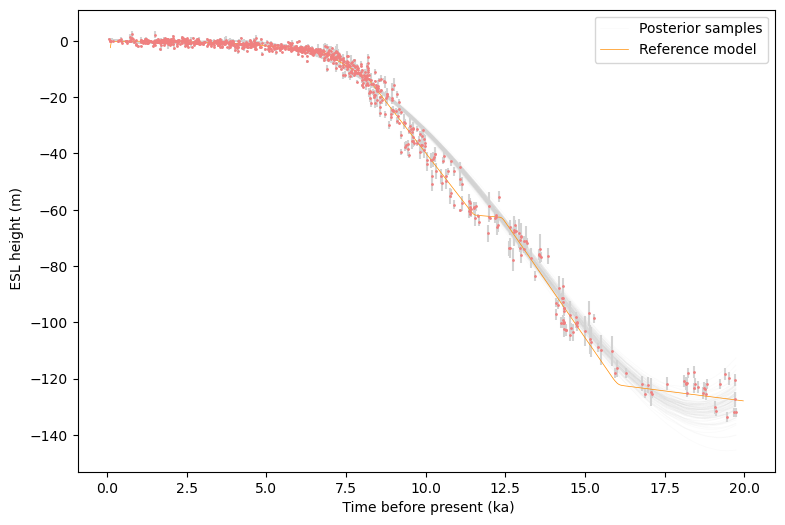

In [40]:
#@title Solution

m_lower_bound = np.array([-1.0,-10,-10,-10])             # lower bound for uniform prior
m_upper_bound = np.array([1.0,10,10,10])                 # upper bound for uniform prior

def log_prior(model):    # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

######## CoFI BaseProblem - update information
inv_problem.set_log_prior(log_prior)

######## CoFI Inversion - run it
inv_4 = Inversion(inv_problem, inv_options_3)
inv_result_4 = inv_4.run()

flat_samples = inv_result_4.sampler.get_chain(discard=300, thin=30, flat=True)
inds = np.random.randint(len(flat_samples), size=100) # get a random selection from posterior ensemble

print("Resulting samples with prior model lower bounds of [-1,-10,-10,-10], upper bounds of [2,10,10,10]")
plot_data()
plot_models(flat_samples[inds],color="lightgrey")
plot_model(ref_x, ref_y, "Reference model", color="darkorange")

Is there much change to the posterior distribution?

---

## Watermark

In [41]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.3.dev0
numpy 1.21.6
scipy 1.10.1
matplotlib 3.7.1
emcee 3.1.4
arviz 0.15.1
